# Disease-state discovery on HLCA - prepare datasets

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import oor_benchmark

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import milopy

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [813]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [6]:
import matplotlib

def plot_milo_diagnostics(nhood_adata, alpha = 0.1, figsize=[12, 12]):
    with matplotlib.rc_context({"figure.figsize": figsize}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(nhood_adata.obs["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(nhood_adata.obs["PValue"], nhood_adata.obs["SpatialFDR"], s=3)
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            nhood_adata.obs["logFC"], -np.log10(nhood_adata.obs["SpatialFDR"]), s=3
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = nhood_adata.obs
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()

In [7]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [8]:
%%R -i design_palette_df 
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


## Run milo DA analysis

In [281]:
# ar_correct = sc.read_h5ad(data_dir + "Kaminski_2020_oor_design.AR.h5ad", backed=True)
# ar_adata = sc.read_h5ad(data_dir + "tmp/Kaminski_2020_oor_design.AR.h5ad", backed=True)
# ar_adata.obs['disease'] = ar_correct[ar_adata.obs_names].obs['disease']
# ar_adata.obs['disease'].cat.categories
# ar_adata.write_h5ad()

## Parse results

In [9]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/HLCA/'

In [10]:
acr_adata = milopy.utils.read_milo_adata(data_dir + "Kaminski_2020_oor_design.ACR.h5ad")

In [11]:
ar_adata = milopy.utils.read_milo_adata(data_dir + "Kaminski_2020_oor_design.AR.h5ad", backed=True)

In [12]:
cr_adata = milopy.utils.read_milo_adata(data_dir + "Kaminski_2020_oor_design.CR.h5ad", backed=True)

In [14]:
all_cts = ar_adata.obs['Celltype_HLCA'].unique().tolist()
all_cts.sort()

ct_groups = {}
ct_groups['macrophages'] = [x for x in all_cts if 'macro' in x or 'Mφ' in x]
ct_groups['fibroblasts'] = [x for x in all_cts if 'fibroblast' in x]
ct_groups['basal'] = [x for x in all_cts if 'basal' in x or "Basal" in x]
ct_groups['AT'] = [x for x in all_cts if "AT" in x]
ct_groups['EC'] = [x for x in all_cts if "EC" in x]
ct_groups['Club'] = [x for x in all_cts if "Club" in x]
ct_groups['Goblet'] = [x for x in all_cts if "Goblet" in x]
ct_groups['SMG'] = [x for x in all_cts if "SMG" in x]
ct_groups['Multiciliated'] = [x for x in all_cts if "Multiciliated" in x]

ct_groups['Lymphoid'] = ['B cells',
 'CD4 T cells',
 'CD8 T cells',
  'NK cells',
'Plasma cells',
 'T cells proliferating']
    
ct_groups['Myeloid'] = [
 'Mast cells',
'Classical monocytes',
 'DC1',
 'DC2',
 'Migratory DCs',
 'Non-classical monocytes',
 'Plasmacytoid DCs'    
]
 
min_cells = 10

ct_groups_rev = {x:k for k,v in ct_groups.items() for x in v}
for ct in all_cts:
    if sum(acr_adata.obs['Celltype_HLCA'] == ct) < min_cells:
        ct_groups_rev[ct] = np.nan
    else:        
        if ct not in ct_groups_rev.keys():
            ct_groups_rev[ct] = ct


## Compare scArches integration to scANVI integration on CR design

In [15]:
cr_scarches_adata = milopy.utils.read_milo_adata(data_dir + "Kaminski_2020_oor_design.CR.scArches.h5ad", backed=True)

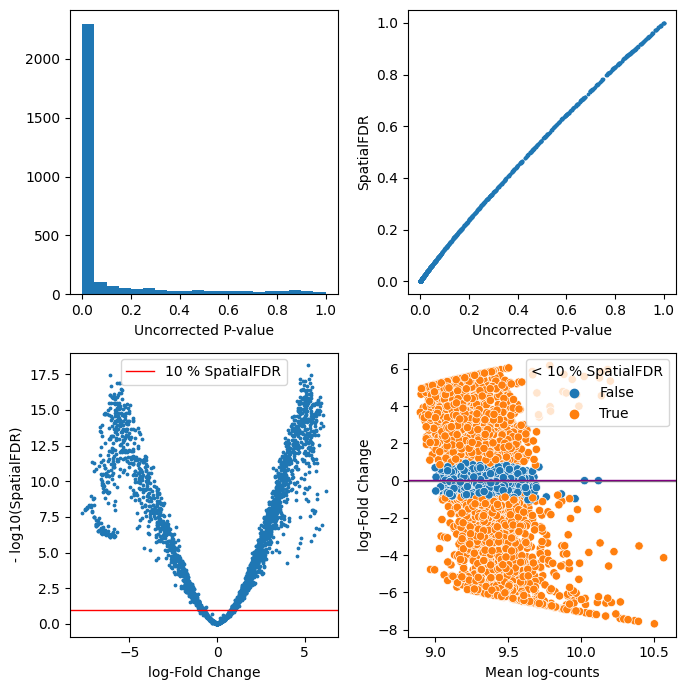

In [17]:
plot_milo_diagnostics(cr_adata.uns['nhood_adata'], figsize=(7,7))

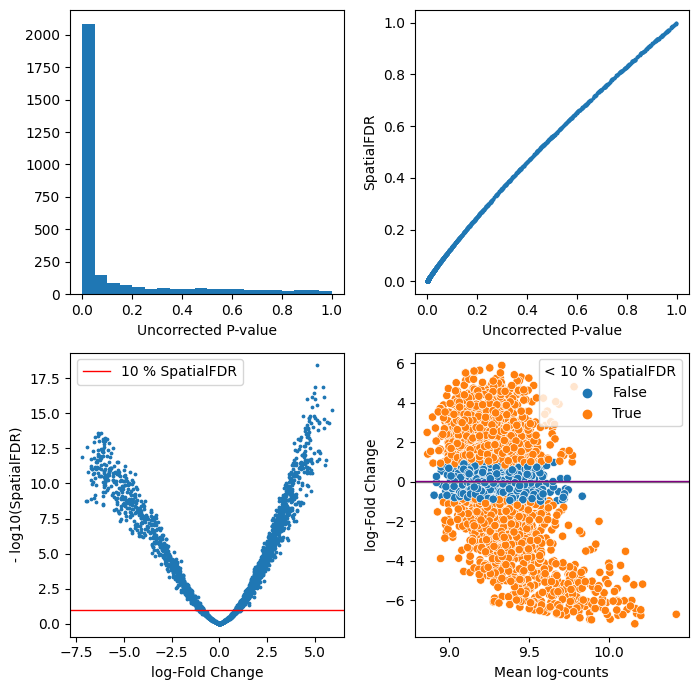

In [16]:
plot_milo_diagnostics(cr_scarches_adata.uns['nhood_adata'], figsize=(7,7))

In [27]:
ar_adata.uns['nhood_adata'] = ar_adata.uns['nhood_adata'].to_memory()
cr_adata.uns['nhood_adata'] = cr_adata.uns['nhood_adata'].to_memory()
cr_scarches_adata.uns['nhood_adata'] = cr_scarches_adata.uns['nhood_adata'].to_memory()

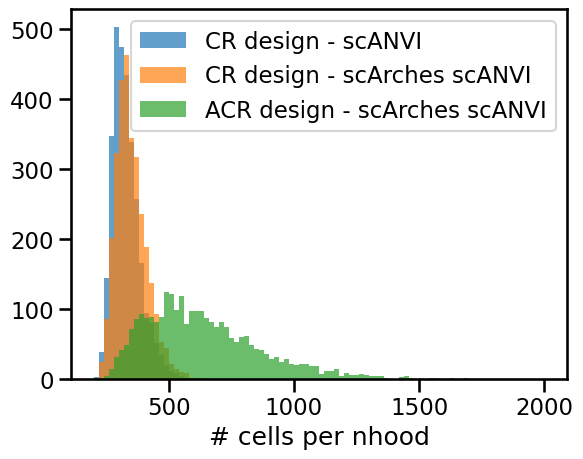

In [30]:
sns.set_context('talk')
binwidth = 20
plt.hist(np.array(cr_adata.obsm['nhoods'].sum(axis=0)).flatten(), bins=np.arange(200, 2000 + binwidth, binwidth), alpha=0.7, label='CR design - scANVI');
plt.hist(np.array(cr_scarches_adata.obsm['nhoods'].sum(axis=0)).flatten(), bins=np.arange(200, 2000 + binwidth, binwidth), alpha=0.7, label='CR design - scArches scANVI');
plt.hist(np.array(acr_adata.obsm['nhoods'].sum(axis=0)).flatten(), bins=np.arange(200, 2000 + binwidth, binwidth), alpha=0.7, label='ACR design - scArches scANVI');
plt.legend();
plt.xlabel('# cells per nhood');
plt.show()

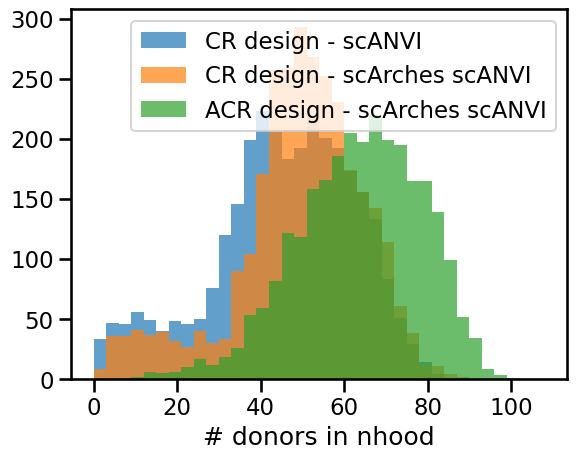

In [31]:
binwidth=3
nhood_adata = cr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='CR design - scANVI'
        );

nhood_adata = cr_scarches_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='CR design - scArches scANVI'
        );


nhood_adata = acr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='ACR design - scArches scANVI'
        );
plt.legend()
plt.xlabel('# donors in nhood');
plt.show()

In [22]:
sc.tl.umap(cr_adata)
sc.tl.umap(cr_scarches_adata)

2023-01-13 13:19:37.124321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 13:19:37.556151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:/usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server
2023-01-13 13:19:37.556185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-13 13:19:37.597571: E tensorflow/s

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


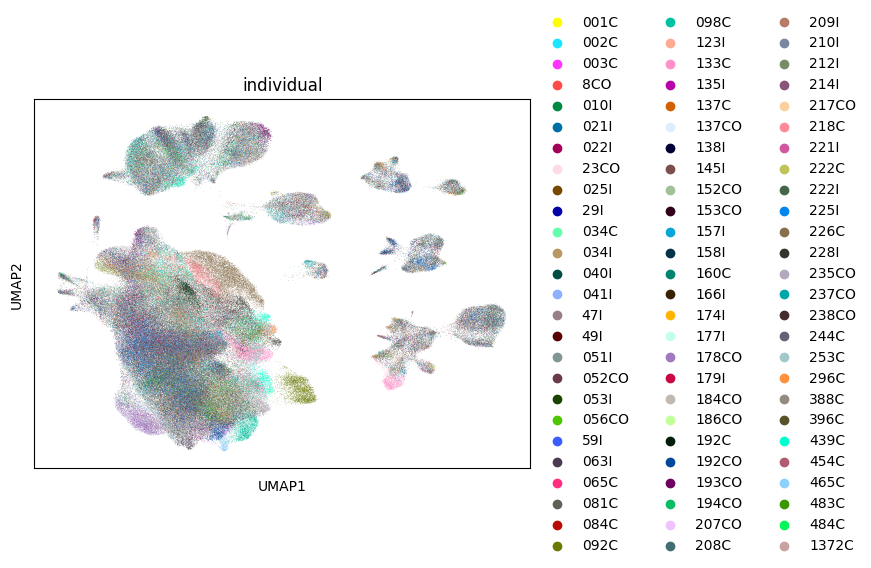

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


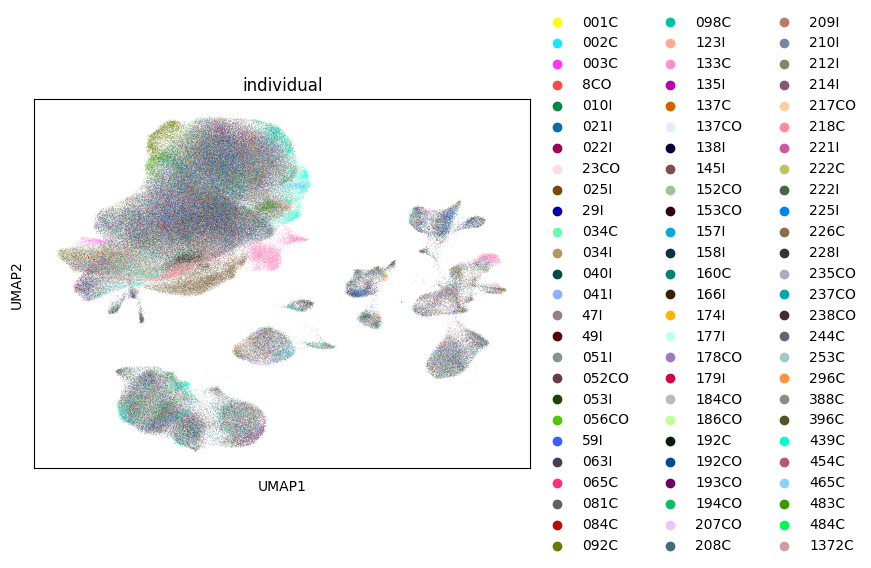

In [24]:
sc.pl.umap(cr_adata, color='individual')
sc.pl.umap(cr_scarches_adata, color='individual')

## Compute IPF/fibrosis signature for evaluation
Signature downloaded from [here](https://bmcmedgenomics.biomedcentral.com/articles/10.1186/1755-8794-4-70#Abs1)

In [34]:
acr_adata.var = acr_adata.var.set_index("gene_name")

In [35]:
IPF_signature = pd.read_csv('/home/jovyan/mount/gdrive/patho-signatures/data/IPF_signature_Meltzer2011.csv') 
IPF_signature = IPF_signature.dropna()
IPF_signature = IPF_signature.groupby('Gene').first().reset_index()
IPF_signature = IPF_signature.sort_values('T.stat', ascending=True)
IPF_signature = IPF_signature[IPF_signature['Gene'].isin(acr_adata.var_names)]

IPF_signature_up = IPF_signature[IPF_signature['T.stat'] > 0]['Gene'].values
IPF_signature_down = IPF_signature[IPF_signature['T.stat'] < 0]['Gene'].values

In [174]:
df = IPF_signature[IPF_signature['T.stat'] > 0]

In [194]:
'SPP1' in IPF_signature['Gene']

False

In [197]:
IPF_signature_up

array(['ANO1', 'ROBO1', 'STMN1', 'COL15A1', 'ROGDI', 'GPX8', 'IGFBP7',
       'RTP4', 'DYRK2', 'FGF1', 'RGS10', 'SCARA3', 'ZNF562', 'ZNF785',
       'ST13', 'NSUN5', 'PDLIM5', 'MZF1', 'ASPM', 'COL1A1', 'SSPN',
       'DDB2', 'NAPEPLD', 'COL8A2', 'COL3A1', 'ASPN', 'ROBO2', 'CXXC5',
       'KIAA0895L', 'ABCC3', 'HGSNAT', 'LRRC17', 'SUPT7L', 'ENC1',
       'PHPT1', 'CFH', 'SMARCC1', 'TSHZ2', 'TRADD', 'PEX12', 'TCEAL7',
       'CDCA7', 'ITGB8', 'RPS27L', 'ZNF573', 'CDCP1', 'PPP2R5E', 'TM7SF3',
       'ZNF260', 'TYMS', 'TSPAN11', 'PTGFRN', 'CXCL12', 'ZNF423',
       'PLXDC1', 'RNF150', 'ECM2', 'PHLDA3', 'ANTXR1', 'C11orf80',
       'FNDC1', 'MDK', 'TTC3', 'PSD3', 'CRIP1', 'CACNB3', 'ZMAT3'],
      dtype=object)

Compute weighted signature score

In [36]:
from scipy.sparse import issparse

def _sparse_nanmean(X, axis):
    """
    np.nanmean equivalent for sparse matrices
    """
    if not issparse(X):
        raise TypeError("X must be a sparse matrix")

    # count the number of nan elements per row/column (dep. on axis)
    Z = X.copy()
    Z.data = np.isnan(Z.data)
    Z.eliminate_zeros()
    n_elements = Z.shape[axis] - Z.sum(axis)

    # set the nans to 0, so that a normal .sum() works
    Y = X.copy()
    Y.data[np.isnan(Y.data)] = 0
    Y.eliminate_zeros()

    # the average
    s = Y.sum(axis, dtype='float64')  # float64 for score_genes function compatibility)
    m = s / n_elements

    return m

def _weighted_score_genes(adata, gene_list, gene_weights, gene_pool=None, use_raw=False, n_bins=25):
    '''Adapting code from scanpy.tl.score_genes'''
    var_names = adata.var_names
    
    if gene_pool is None:
        gene_pool = list(var_names)
    else:
        gene_pool = [x for x in gene_pool if x in var_names]
    if not gene_pool:
        raise ValueError("No valid genes were passed for reference set.")

    # Trying here to match the Seurat approach in scoring cells.
    # Basically we need to compare genes against random genes in a matched
    # interval of expression.

    _adata = adata.raw if use_raw else adata
    _adata_subset = (
        _adata[:, gene_pool] if len(gene_pool) < len(_adata.var_names) else _adata
    )
    if issparse(_adata_subset.X):
        obs_avg = pd.Series(
            np.array(_sparse_nanmean(_adata_subset.X, axis=0)).flatten(),
            index=gene_pool,
        )  # average expression of genes
    else:
        obs_avg = pd.Series(
            np.nanmean(_adata_subset.X, axis=0), index=gene_pool
        )  # average expression of genes

    obs_avg = obs_avg[
        np.isfinite(obs_avg)
    ]  # Sometimes (and I don't know how) missing data may be there, with nansfor

    n_items = int(np.round(len(obs_avg) / (n_bins - 1)))
    obs_cut = obs_avg.rank(method='min') // n_items
    control_genes = list()
    control_weights = list()

    # now pick `ctrl_size` genes from every cut
    for cut in np.unique(obs_cut.loc[gene_list]):
        bin_genes_ixs = obs_cut.loc[gene_list] == cut
        ctrl_size_cut = sum(bin_genes_ixs)
        r_genes = np.array(obs_cut[obs_cut == cut].index)
        np.random.shuffle(r_genes)
        # uses full r_genes if ctrl_size > len(r_genes)
        control_genes.extend(list(set(r_genes[:ctrl_size_cut])))
        control_weights.extend(gene_weights[bin_genes_ixs])

    # To index, we need a list – indexing implies an order.
    control_genes = list(control_genes)
    gene_list = list(gene_list)

    X_list = _adata[:, gene_list].X.toarray()
    X_list = np.average(X_list, axis=1, weights=gene_weights)
    
    X_control = _adata[:, control_genes].X.toarray()
    X_control = np.average(X_control, axis=1, weights=control_weights)
    score = X_list - X_control
    return(score)

In [37]:
from sklearn.preprocessing import normalize

# Use only up regulated genes
IPF_signature = IPF_signature[IPF_signature['T.stat'] > 0]
IPF_signature_genes = IPF_signature['Gene'].values
IPF_signature_weights = normalize(IPF_signature['T.stat'].values.reshape(1,-1)).flatten()

In [215]:
df = pd.DataFrame(np.vstack([IPF_signature_weights, IPF_signature_genes]).T, columns=['weight', 'gene'])
df['weight'] = df['weight'].astype('float64')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


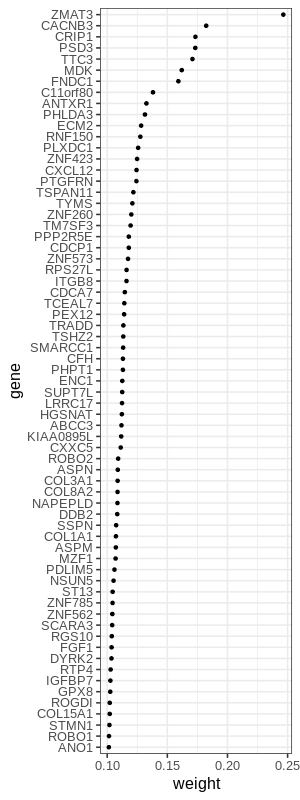

In [223]:
%%R -i df -h 800 -w 300
df %>%
arrange(weight) %>%
mutate(gene=factor(gene, levels=unique(gene))) %>%
ggplot(aes(weight,gene)) +
theme_bw(base_size=16) +
geom_point() 

In [38]:
sc.pp.normalize_total(acr_adata, target_sum=10000)
sc.pp.log1p(acr_adata)

In [39]:
acr_adata.obs['IPF_signature'] = _weighted_score_genes(
    acr_adata, 
    gene_list=IPF_signature_genes, 
    gene_weights=IPF_signature_weights)

In [157]:
n_cts = df['Celltype_HLCA'].nunique()

3

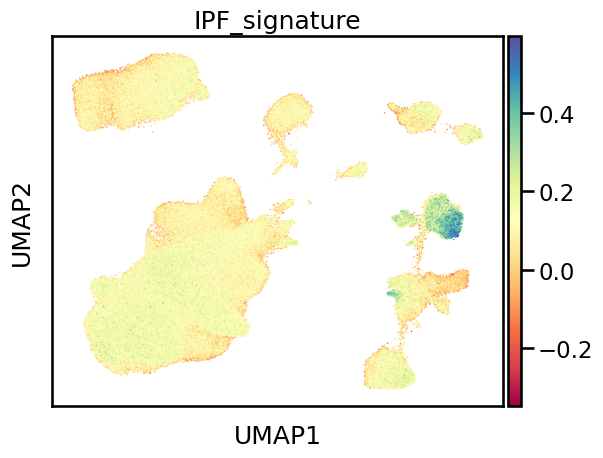

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


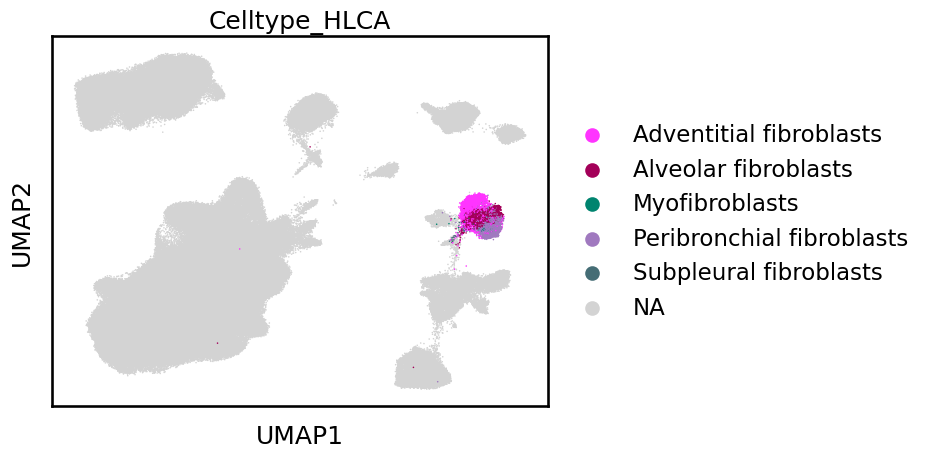

In [169]:
sc.pl.umap(acr_adata, color='IPF_signature', size=5, cmap='Spectral');
sc.pl.umap(acr_adata, color='Celltype_HLCA', size=5, groups=ct_groups['fibroblasts']);

In [346]:
acr_adata.obs['ct_group'] = [ct_groups_rev[ct] for ct in acr_adata.obs['Celltype_HLCA']]

In [365]:
import scipy.stats as st

In [ ]:
dof = len(x)-1 
confidence = 0.95
t_crit = np.abs(t.ppf((1-confidence)/2,dof))

In [407]:
# def get_conf_interval_min(data):
#     return(st.t.interval(alpha=0.99, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))[0])
# def get_conf_interval_max(data):
#     return(st.t.interval(alpha=0.99, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))[1])

In [408]:
CI_sign_min = acr_adata[acr_adata.obs['disease'] == 'Control'].obs[['IPF_signature', 'ct_group']].groupby('ct_group').quantile(0.25)
CI_sign_max = acr_adata[acr_adata.obs['disease'] == 'Control'].obs[['IPF_signature', 'ct_group']].groupby('ct_group').quantile(0.75)

null_sign_range = pd.concat([CI_sign_min, CI_sign_max], 1)
null_sign_range.columns = ['null_min', 'null_max']

/tmp/ipykernel_52687/580862689.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  null_sign_range = pd.concat([CI_sign_min, CI_sign_max], 1)


/tmp/ipykernel_52687/3199755873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.remove_unused_categories()
/tmp/ipykernel_52687/3199755873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.reorder_categories(['IPF', "Control"])
/tmp/ipykernel_52687/3199755873.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

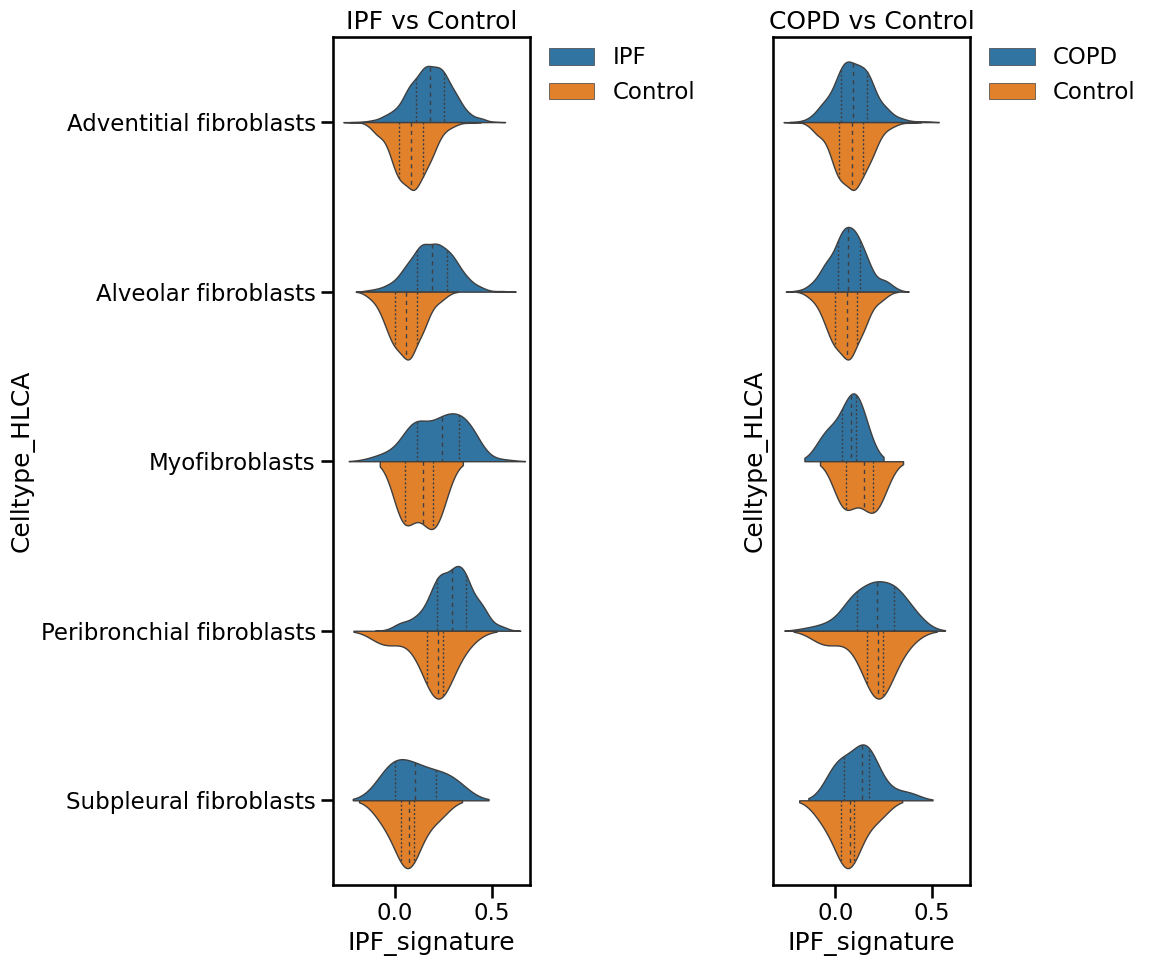

/tmp/ipykernel_52687/3199755873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.remove_unused_categories()
/tmp/ipykernel_52687/3199755873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.reorder_categories(['IPF', "Control"])
/tmp/ipykernel_52687/3199755873.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

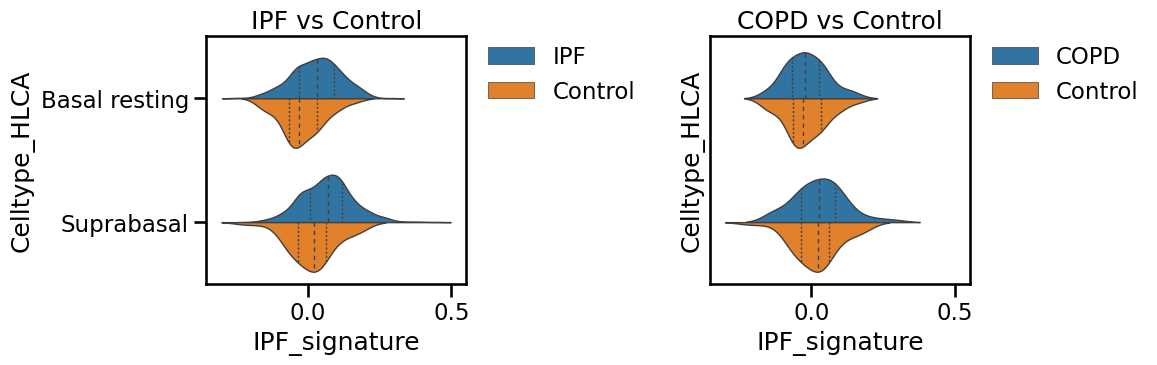

/tmp/ipykernel_52687/3199755873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.remove_unused_categories()
/tmp/ipykernel_52687/3199755873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.reorder_categories(['IPF', "Control"])
/tmp/ipykernel_52687/3199755873.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

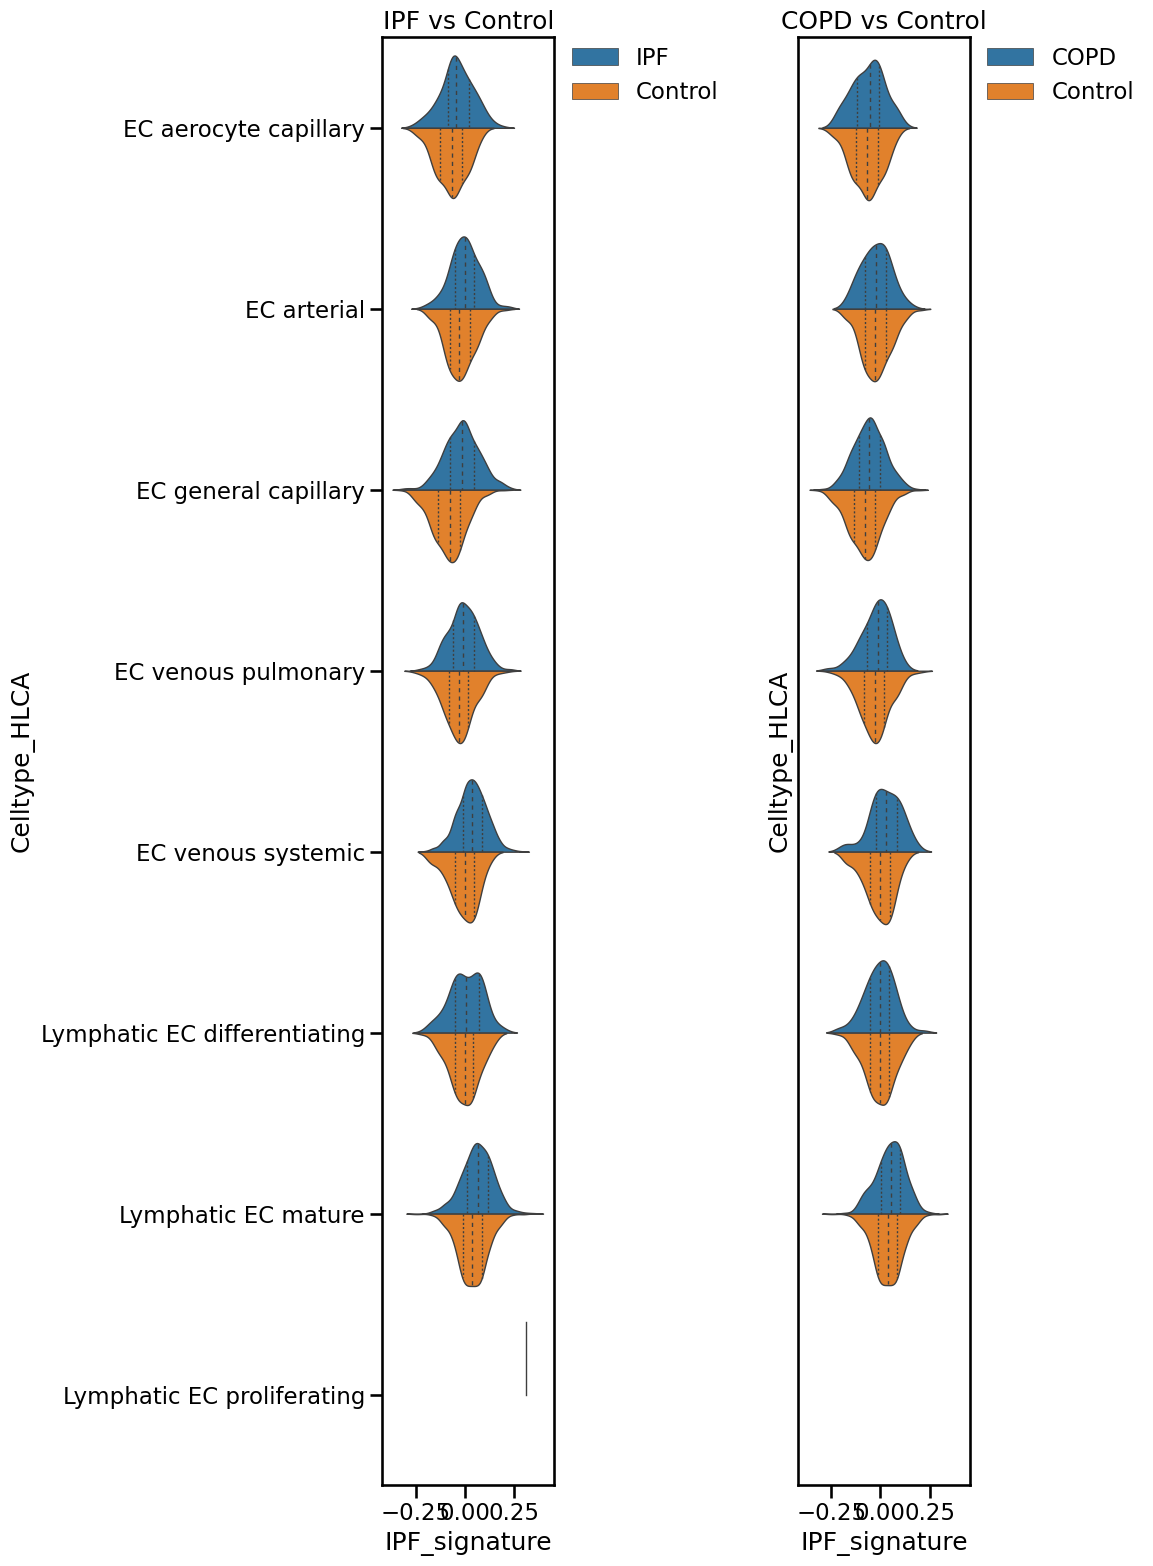

/tmp/ipykernel_52687/3199755873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.remove_unused_categories()
/tmp/ipykernel_52687/3199755873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.reorder_categories(['IPF', "Control"])
/tmp/ipykernel_52687/3199755873.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

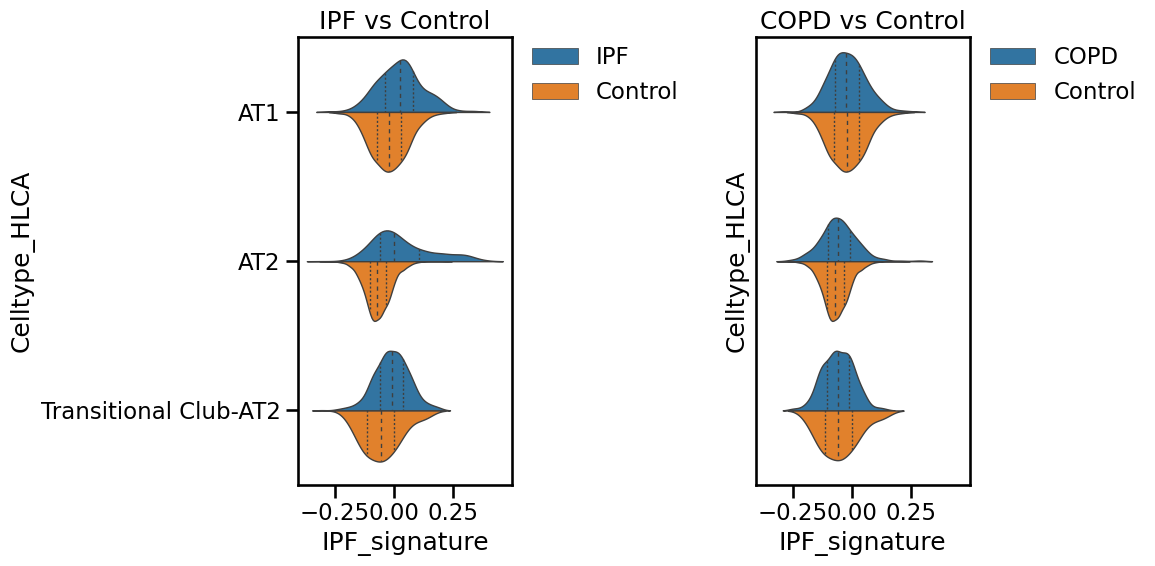

/tmp/ipykernel_52687/3199755873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.remove_unused_categories()
/tmp/ipykernel_52687/3199755873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['disease'] = df1['disease'].cat.reorder_categories(['IPF', "Control"])
/tmp/ipykernel_52687/3199755873.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

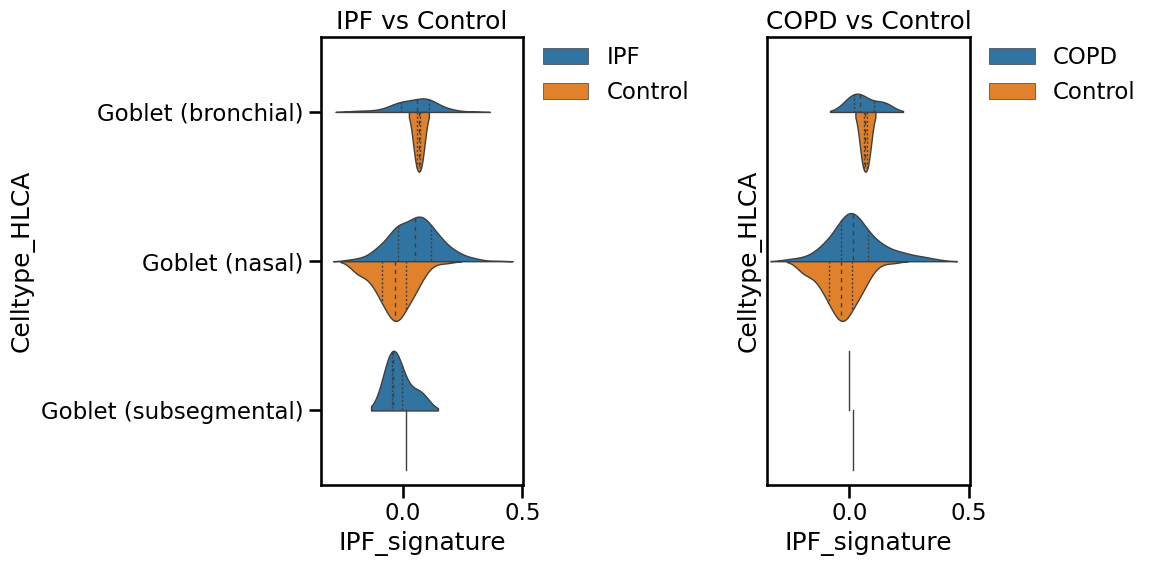

In [776]:
for gr in ['fibroblasts', 'basal', 'EC', 'AT', "Goblet"]:
    df = sc.get.obs_df(acr_adata, ['IPF_signature', 'Celltype_HLCA', 'disease'])
    df = df[df['Celltype_HLCA'].isin(ct_groups[gr])].copy()
    df['Celltype_HLCA'] = df['Celltype_HLCA'].cat.remove_unused_categories() 

    df1 = df[df['disease'].isin(['Control', "IPF"])]
    df1['disease'] = df1['disease'].cat.remove_unused_categories() 
    df1['disease'] = df1['disease'].cat.reorder_categories(['IPF', "Control"])

    df2 = df[df['disease'].isin(['Control', "COPD"])]
    df2['disease'] = df2['disease'].cat.remove_unused_categories() 

    sns.set_context('talk')
    n_cts = df['Celltype_HLCA'].nunique()
    with plt.rc_context({'figure.figsize':[12,2*n_cts]}):
        plt.subplot(1,2,1);
        sns.violinplot(data=df1, y='Celltype_HLCA', x='IPF_signature', hue="disease",
                        split=True, inner="quart", linewidth=1, );
        plt.xlim(df['IPF_signature'].min() - 0.1, df['IPF_signature'].max()+ 0.1)
        plt.title('IPF vs Control');
        plt.legend(
          bbox_to_anchor=(1.05, 1), # relative position on x and y axis (> 1 indicates outside of axis)
          loc='upper left', # equiv to hjust/vjust in ggplot
          borderaxespad=0, # The pad between the axes and legend border, in font-size units.
          frameon=False,
          title='')
        plt.subplot(1,2,2);
        sns.violinplot(data=df2, y='Celltype_HLCA', x='IPF_signature', hue="disease",
                        split=True, inner="quart", linewidth=1, );
        plt.xlim(df['IPF_signature'].min()- 0.1, df['IPF_signature'].max()+ 0.1)
        plt.title('COPD vs Control');
        plt.yticks([])
        plt.tick_params(axis='both', left=False, top=False, right=False, bottom=True, labelleft=False, labeltop=False, labelright=False, labelbottom=True)
        plt.legend(
          bbox_to_anchor=(1.05, 1), # relative position on x and y axis (> 1 indicates outside of axis)
          loc='upper left', # equiv to hjust/vjust in ggplot
          borderaxespad=0, # The pad between the axes and legend border, in font-size units.
          frameon=False,
          title='')
        plt.tight_layout();
        plt.show()

In [651]:
# ## Add signature to all designs (restrict to disease cells, cos ctrl is missing from AR)
acr_adata.obs['IPF_signature_disease'] = np.nan
acr_adata.obs.loc[acr_adata.obs['disease'] == 'IPF','IPF_signature_disease'] = acr_adata.obs.loc[acr_adata.obs['disease'] == 'IPF','IPF_signature']

cr_adata.obs['IPF_signature'] = np.nan
cr_adata.obs.loc[acr_adata.obs_names, 'IPF_signature'] = acr_adata.obs['IPF_signature'].values

cr_adata.obs['IPF_signature_disease'] = np.nan
cr_adata.obs.loc[acr_adata.obs_names, 'IPF_signature_disease'] = acr_adata.obs['IPF_signature_disease'].values
ar_adata.obs['IPF_signature_disease'] = np.nan
ar_adata.obs.loc[acr_adata.obs_names[acr_adata.obs['disease'] == 'IPF'] +"_adams", 'IPF_signature_disease'] = acr_adata.obs.loc[acr_adata.obs['disease'] == 'IPF', 'IPF_signature_disease'].values

## Quality control milo results

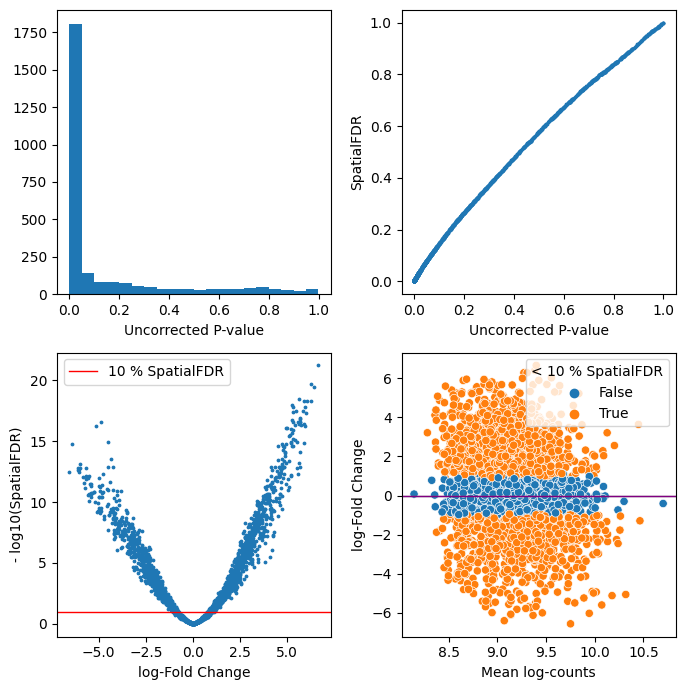

In [16]:
plot_milo_diagnostics(acr_adata.uns['nhood_adata'], figsize=(7,7))

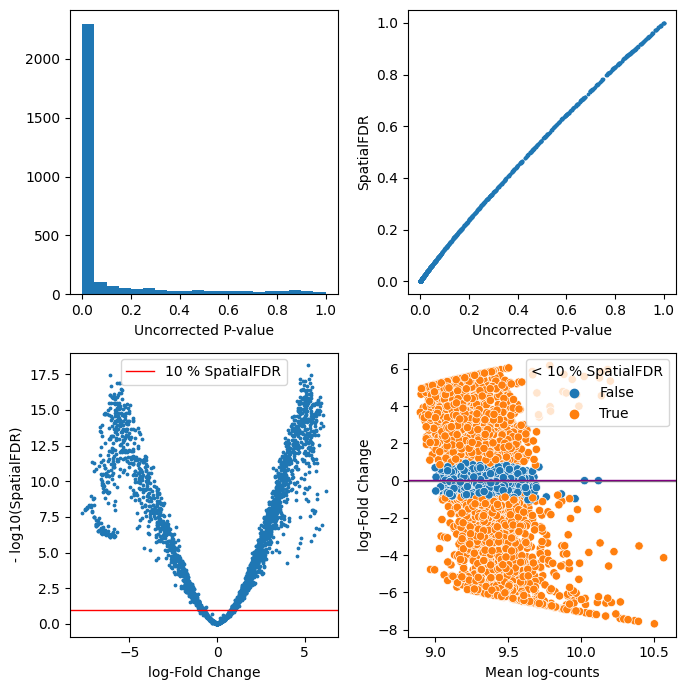

In [17]:
plot_milo_diagnostics(cr_adata.uns['nhood_adata'], figsize=(7,7))

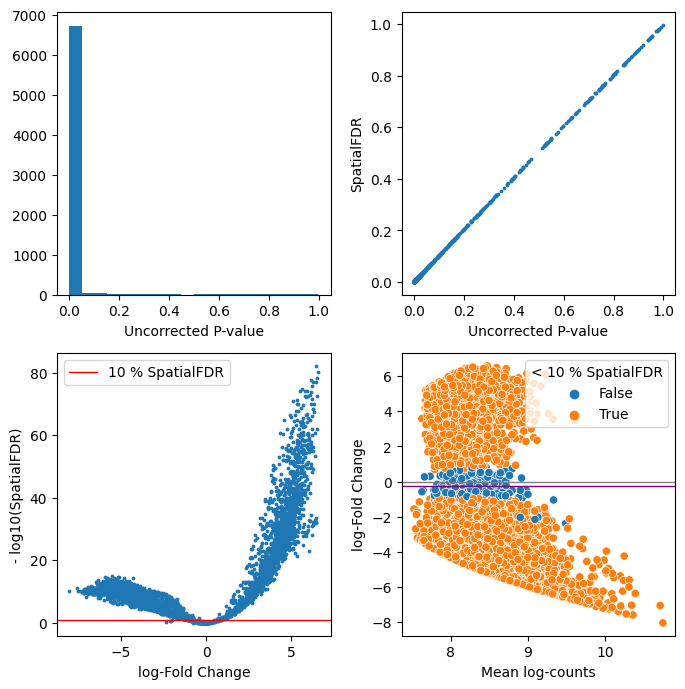

In [18]:
plot_milo_diagnostics(ar_adata.uns['nhood_adata'], figsize=(7,7))

In [323]:
suspicious_nhs = nhood_CR_df[(nhood_CR_df['logFC'] < -5) & (-np.log10(nhood_CR_df['SpatialFDR']) < 8)].index

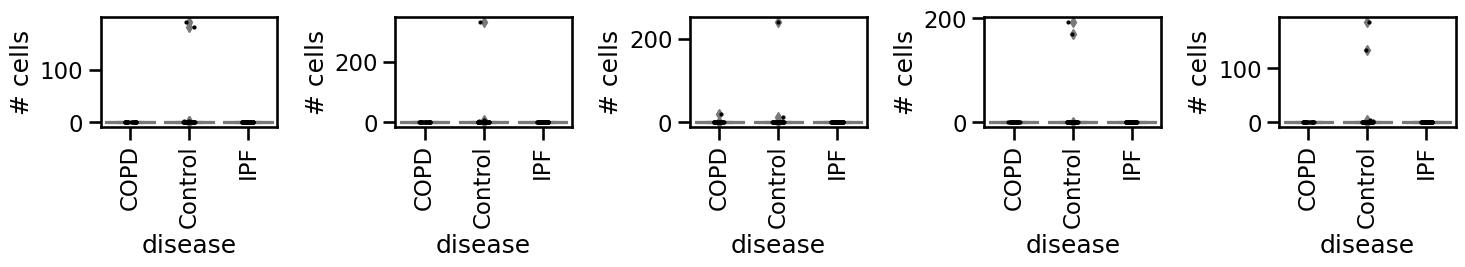

In [330]:
sns.set_context('talk')
n_iters=5
with plt.rc_context({'figure.figsize':[15,3]}):
    for i in np.arange(n_iters):
        plt.subplot(1,n_iters, i+1);
        milopy.plot.plot_nhood_counts_by_cond(cr_adata, test_var='disease', subset_nhoods=np.random.choice(suspicious_nhs, 1));
    plt.tight_layout()
    plt.show()

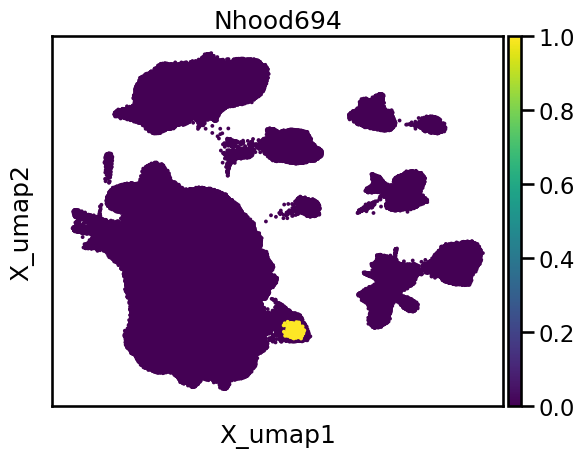

In [337]:
milopy.plot.plot_nhood(cr_adata, int(suspicious_nhs[9]))

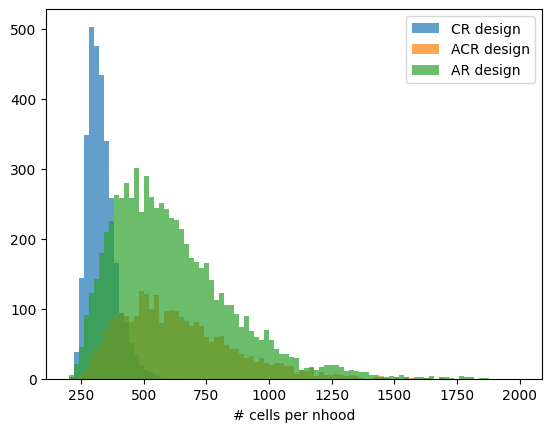

In [19]:
binwidth = 20
plt.hist(np.array(cr_adata.obsm['nhoods'].sum(axis=0)).flatten(), bins=np.arange(200, 2000 + binwidth, binwidth), alpha=0.7, label='CR design');
plt.hist(np.array(acr_adata.obsm['nhoods'].sum(axis=0)).flatten(), bins=np.arange(200, 2000 + binwidth, binwidth), alpha=0.7, label='ACR design');
plt.hist(np.array(ar_adata.obsm['nhoods'].sum(axis=0)).flatten(), bins=np.arange(200, 2000 + binwidth, binwidth), alpha=0.7, label='AR design');
plt.legend();
plt.xlabel('# cells per nhood');
plt.show()

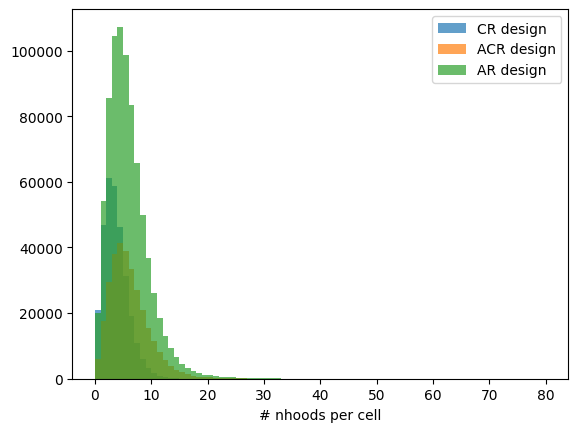

In [21]:
binwidth = 1
plt.hist(np.array(cr_adata.obsm['nhoods'].sum(axis=1)).flatten(), bins=np.arange(0, 80 + binwidth, binwidth), alpha=0.7, label='CR design');
plt.hist(np.array(acr_adata.obsm['nhoods'].sum(axis=1)).flatten(), bins=np.arange(0, 80 + binwidth, binwidth), alpha=0.7, label='ACR design');
plt.hist(np.array(ar_adata.obsm['nhoods'].sum(axis=1)).flatten(), bins=np.arange(0, 80 + binwidth, binwidth), alpha=0.7, label='AR design');
plt.legend();
plt.xlabel('# nhoods per cell');
plt.show()

In [227]:
cr_adata.uns['neighbors']['params']['n_neighbors'] == acr_adata.uns['neighbors']['params']['n_neighbors']

True

Compare embeddings

In [304]:
sc.tl.umap(cr_adata)

2023-01-12 14:14:54.659990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 14:14:54.840613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:/usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server
2023-01-12 14:14:54.840653: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 14:14:54.872221: E tensorflow/s

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


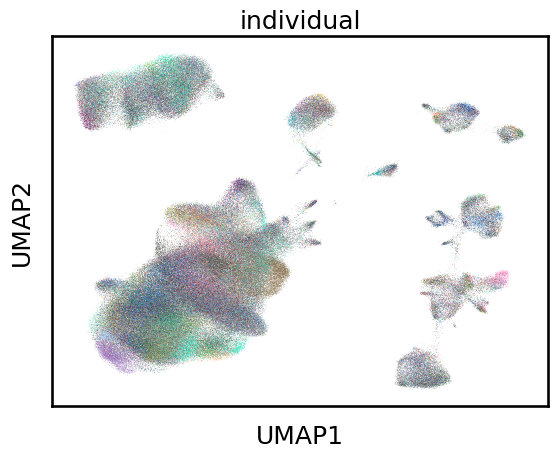

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


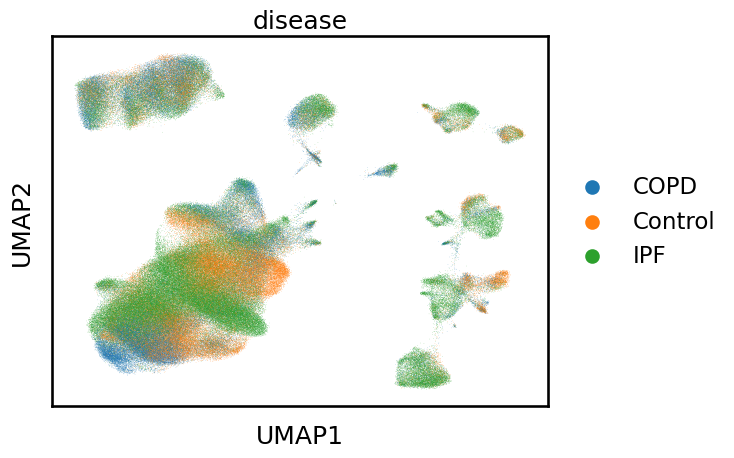

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


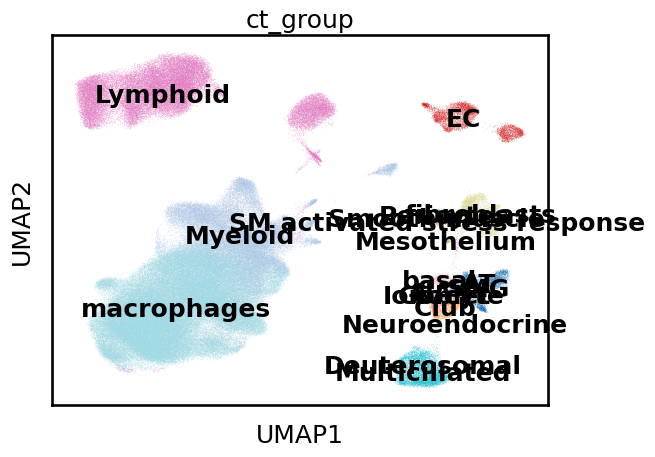

In [812]:
sc.pl.umap(acr_adata, color='individual', legend_loc='none')
sc.pl.umap(acr_adata, color='disease')
sc.pl.umap(acr_adata, color='ct_group', legend_loc='on data')


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


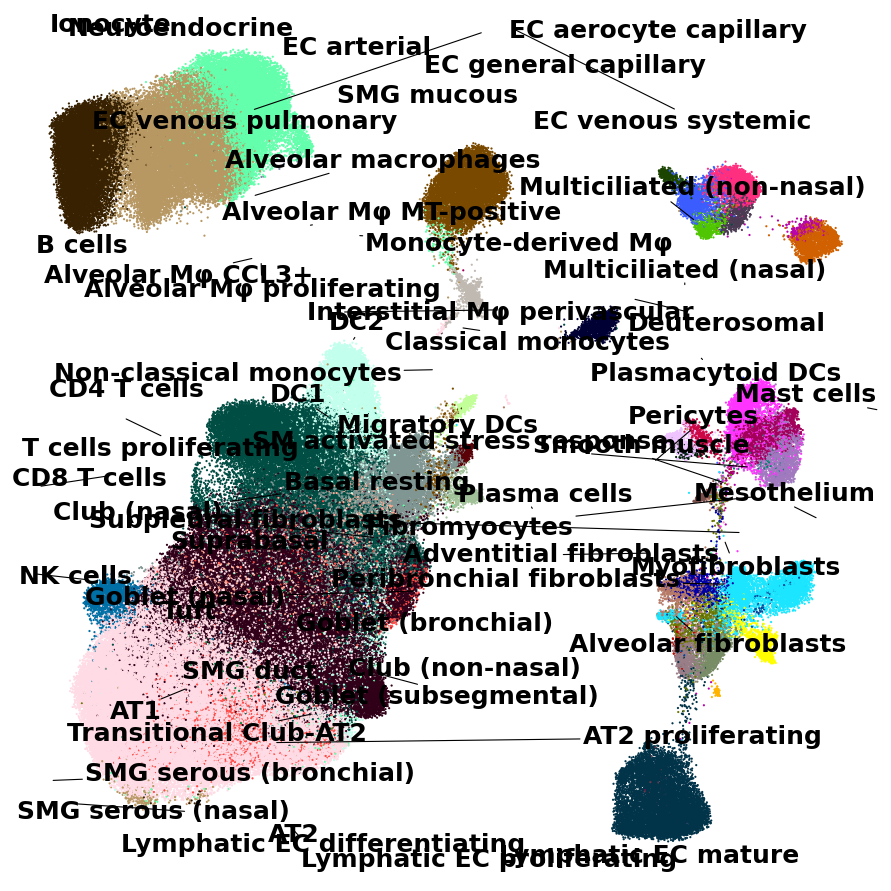

In [818]:
sns.set_context('paper')
with plt.rc_context({'figure.figsize':[9,9]}):
    ax = sc.pl.umap(acr_adata, color=['Celltype_HLCA'], size=10, palette=sc.pl.palettes.godsnot_102,
                legend_fontsize=14, frameon=False,
                title="", show=False, legend_loc=None)
    gen_mpl_labels(
        adata,
        "Celltype_HLCA",
    #     exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=18, fontweight='bold'),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.show()

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


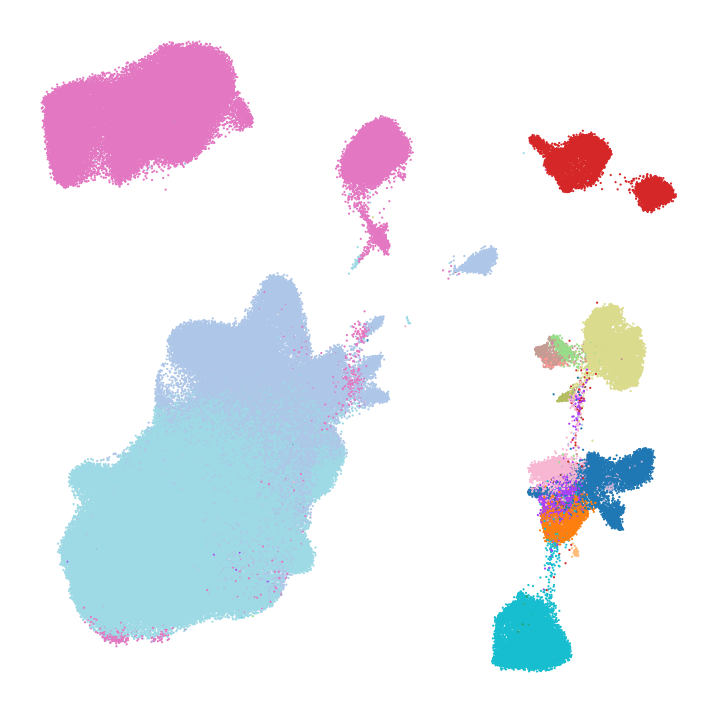

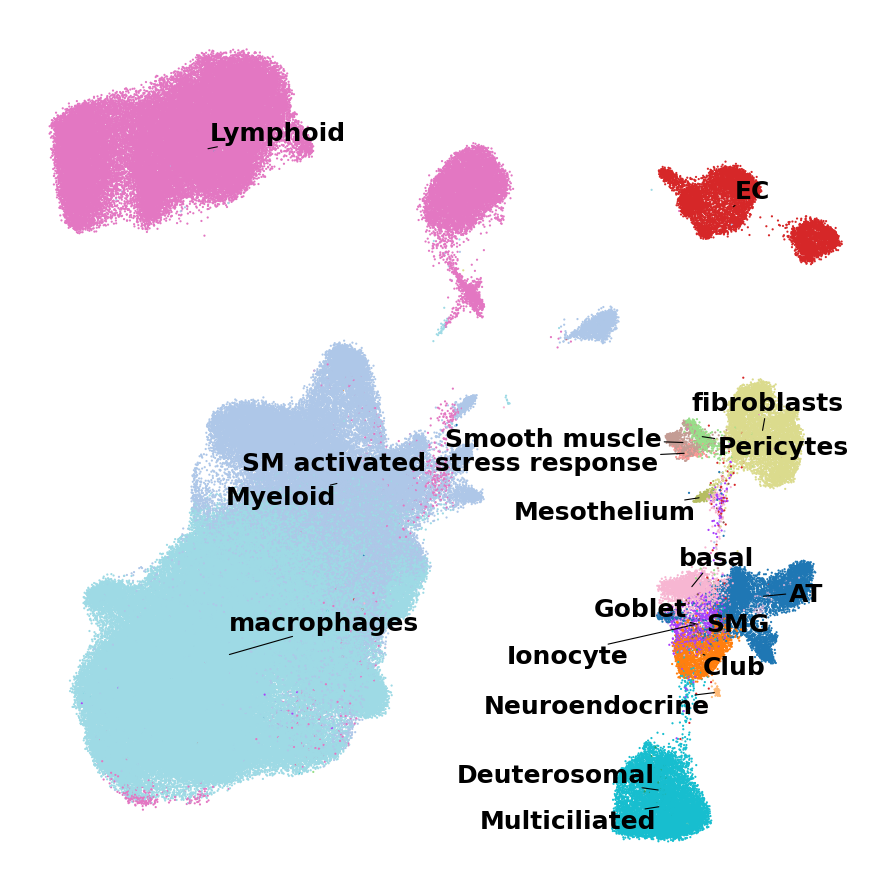

In [820]:
sns.set_context('paper')
with plt.rc_context({'figure.figsize':[9,9]}):
    ax = sc.pl.umap(acr_adata, color=['ct_group'], size=10, 
                legend_fontsize=14, frameon=False,
                title="", show=False, legend_loc=None)
    gen_mpl_labels(
        acr_adata,
        "ct_group",
    #     exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=18, fontweight='bold'),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.show()

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


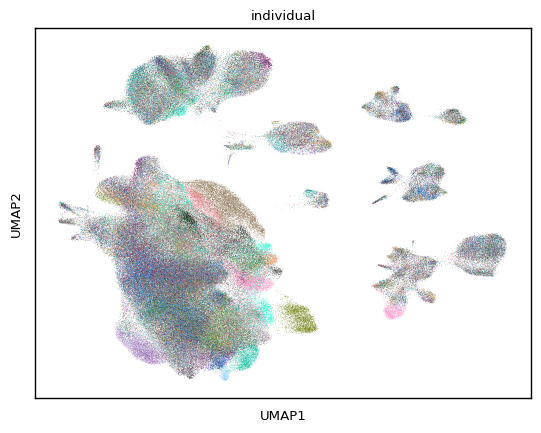

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


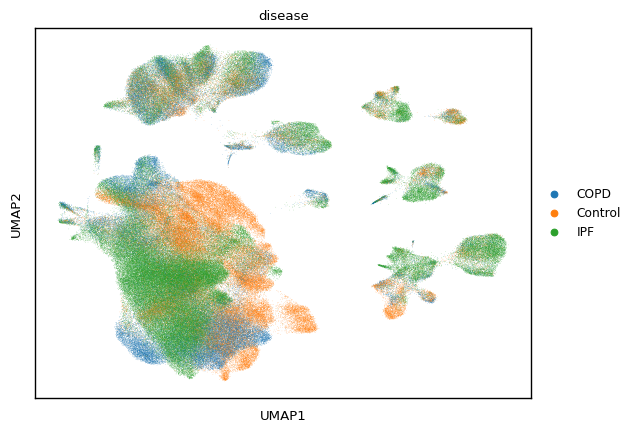

In [308]:
sc.pl.umap(cr_adata, color='individual', legend_loc='none')
sc.pl.umap(cr_adata, color='disease')

No difference in variance

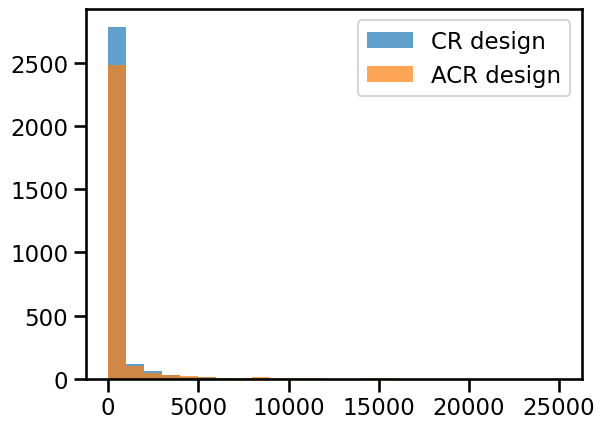

In [369]:
binwidth = 1000

nhood_adata = cr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.toarray()
ctrl_var = milo_mat[:,nhood_adata.var['disease'] == "Control"].var(1)
ipf_var = milo_mat[:,nhood_adata.var['disease'] == "IPF"].var(1)

plt.hist(ctrl_var, 
       bins=np.arange(0, 25000 + binwidth, binwidth), 
         alpha=0.7, label='CR design')

nhood_adata = acr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.toarray()
ctrl_var = milo_mat[:,nhood_adata.var['disease'] == "Control"].var(1)
ipf_var = milo_mat[:,nhood_adata.var['disease'] == "IPF"].var(1)

plt.hist(ctrl_var, 
         bins=np.arange(0, 25000 + binwidth, binwidth), 
         alpha=0.7, label='ACR design')
plt.legend()
plt.show()

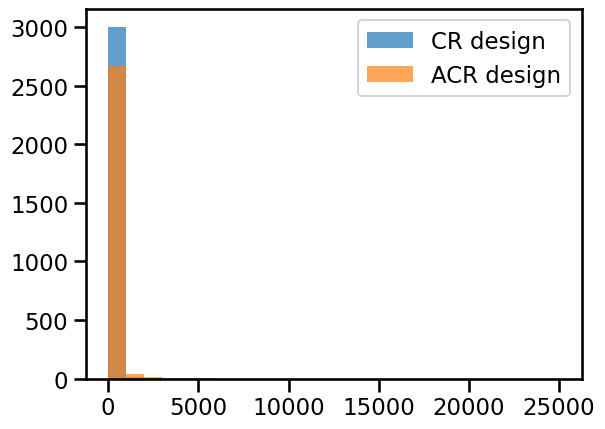

In [370]:
binwidth = 1000

nhood_adata = cr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.toarray()
ctrl_var = milo_mat[:,nhood_adata.var['disease'] == "Control"].var(1)
ipf_var = milo_mat[:,nhood_adata.var['disease'] == "IPF"].var(1)

plt.hist(ipf_var, 
       bins=np.arange(0, 25000 + binwidth, binwidth), 
         alpha=0.7, label='CR design')

nhood_adata = acr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.toarray()
ctrl_var = milo_mat[:,nhood_adata.var['disease'] == "Control"].var(1)
ipf_var = milo_mat[:,nhood_adata.var['disease'] == "IPF"].var(1)

plt.hist(ipf_var, 
         bins=np.arange(0, 25000 + binwidth, binwidth), 
         alpha=0.7, label='ACR design')
plt.legend()
plt.show()

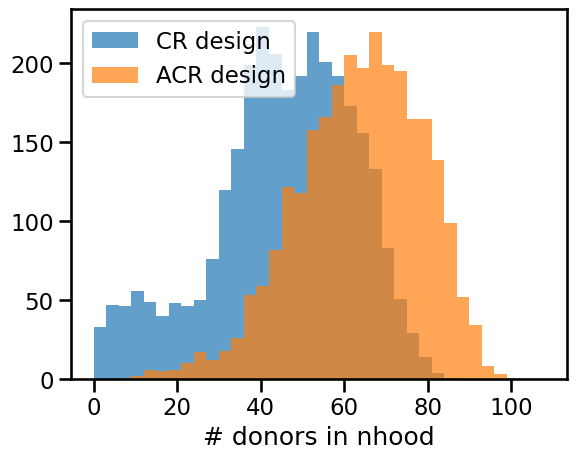

In [389]:
binwidth=3
nhood_adata = cr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='CR design'
        );

nhood_adata = acr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='ACR design'
        );
plt.legend()
plt.xlabel('# donors in nhood');
plt.show()

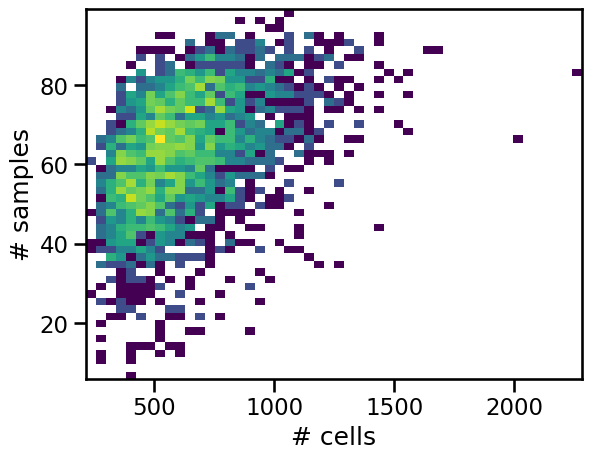

In [404]:
# def get_nhood_stats(acr_adata):
nhood_adata = acr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
n_samples = np.array(milo_mat.sum(1)).flatten()
n_cells = np.array(acr_adata.obsm['nhoods'].sum(0)).flatten()

plt.hist2d(n_cells, n_samples, bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel("# cells"); plt.ylabel('# samples');
plt.show()

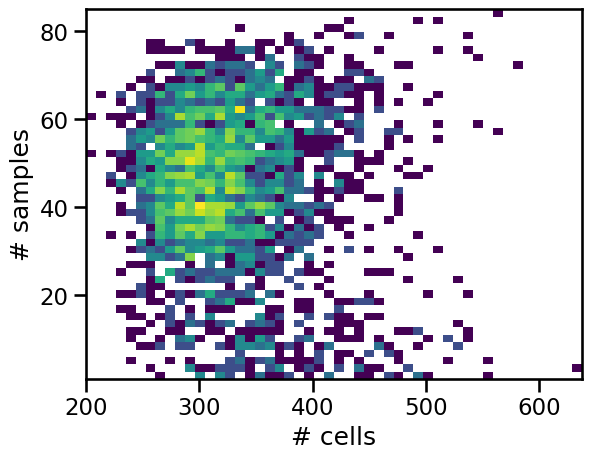

In [405]:
# def get_nhood_stats(acr_adata):
nhood_adata = cr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
n_samples = np.array(milo_mat.sum(1)).flatten()
n_cells = np.array(cr_adata.obsm['nhoods'].sum(0)).flatten()

plt.hist2d(n_cells, n_samples, bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel("# cells"); plt.ylabel('# samples');
plt.show()

## Compare with IPF signature 

In [745]:
## Annotate nhoods by cell type
milopy.utils.annotate_nhoods(acr_adata, anno_col='Celltype_HLCA')
acr_adata.uns['nhood_adata'].obs['nhood_annotation_group'] = [ct_groups_rev[x] for x in acr_adata.uns['nhood_adata'].obs['nhood_annotation']]

milopy.utils.annotate_nhoods(cr_adata, anno_col='Celltype_HLCA')
cr_adata.uns['nhood_adata'].obs['nhood_annotation_group'] = [ct_groups_rev[x] for x in cr_adata.uns['nhood_adata'].obs['nhood_annotation']]

milopy.utils.annotate_nhoods(ar_adata, anno_col='Celltype_HLCA')
ar_adata.uns['nhood_adata'].obs['nhood_annotation_group'] = [ct_groups_rev[x] for x in ar_adata.uns['nhood_adata'].obs['nhood_annotation']]

In [789]:
import scipy
def annotate_nhoods_continuous_nanmean(adata, anno_col):
    nhood_adata = adata.uns['nhood_adata'].copy()
    anno_col_val = np.where(adata.obs[anno_col].isna(), 0, adata.obs[anno_col])
    anno_val = adata.obsm["nhoods"].T.dot(
            scipy.sparse.csr_matrix(anno_col_val).T)
    
    ## Set to nan if less than 5 cells have non nan value 
    # (avoid using the mean of 1/2 cells)
    n_nonnan_cells = np.array(adata.obsm["nhoods"][~adata.obs[anno_col].isna(),:].T.sum(1))
    mean_anno_val = anno_val.toarray()/n_nonnan_cells
    mean_anno_val[n_nonnan_cells < 10] = np.nan

    adata.uns["nhood_adata"].obs[f"nhood_{anno_col}"] = mean_anno_val

In [790]:
## Compute mean IPF signature per nhood
annotate_nhoods_continuous_nanmean(acr_adata, anno_col='IPF_signature_disease')
annotate_nhoods_continuous_nanmean(cr_adata, anno_col='IPF_signature_disease')
annotate_nhoods_continuous_nanmean(ar_adata, anno_col='IPF_signature_disease')

nhood_ACR_df = acr_adata.uns['nhood_adata'].obs.copy()
nhood_ACR_df['design'] = 'ACR'
nhood_AR_df = ar_adata.uns['nhood_adata'].obs.copy()
nhood_AR_df['design'] = 'AR'
nhood_CR_df = cr_adata.uns['nhood_adata'].obs.copy()
nhood_CR_df['design'] = 'CR'

# nhood_CR_df = nhood_CR_df.drop('nhood_IPF_signature_disease', 1)
# nhood_ACR_df = nhood_ACR_df.drop('nhood_IPF_signature_disease', 1)
nhood_ACR_df = nhood_ACR_df[~nhood_ACR_df['nhood_IPF_signature_disease'].isna()]
nhood_CR_df = nhood_CR_df[~nhood_CR_df['nhood_IPF_signature_disease'].isna()]
nhood_AR_df = nhood_AR_df[~nhood_AR_df['nhood_IPF_signature_disease'].isna()]

nhood_df = pd.concat([nhood_ACR_df, nhood_AR_df, nhood_CR_df])
nhood_df['nhood_annotation_frac'] = nhood_df['nhood_annotation_frac'].astype('float64')

/tmp/ipykernel_52687/1800963962.py:11: RuntimeWarning: invalid value encountered in divide
  mean_anno_val = anno_val.toarray()/n_nonnan_cells


In [791]:
%%R -i nhood_df -i null_sign_range
head(nhood_df)
head(null_sign_range)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


                null_min    null_max
AT           -0.09959998 -0.02354429
Club         -0.07800730  0.03199533
Deuterosomal  0.06145112  0.09595207
EC           -0.07342638  0.04792333
Goblet       -0.08445368  0.01388572
Ionocyte     -0.02908260 -0.02908260


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


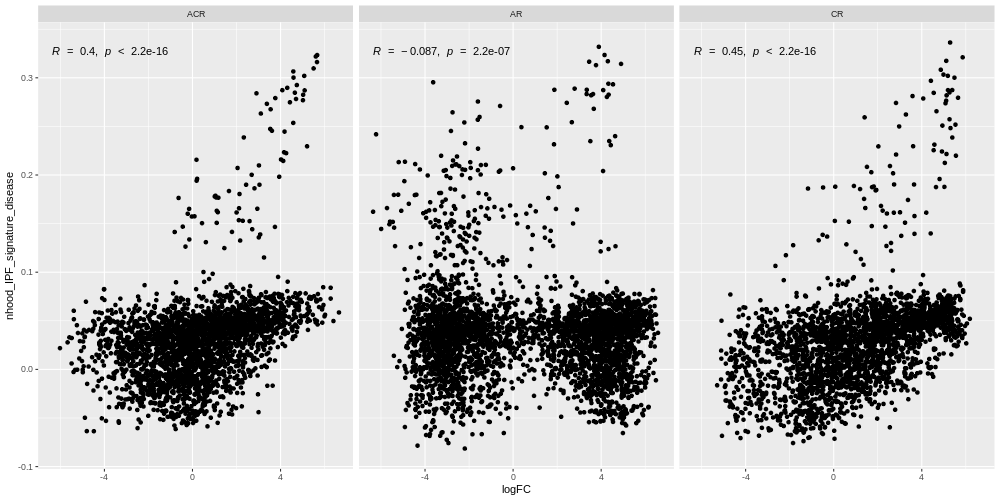

In [792]:
%%R -w 1000 -h 500
nhood_df %>%
    ggplot(aes(logFC, nhood_IPF_signature_disease)) +
    geom_point() +
    facet_grid(.~design) +
    ggpubr::stat_cor()

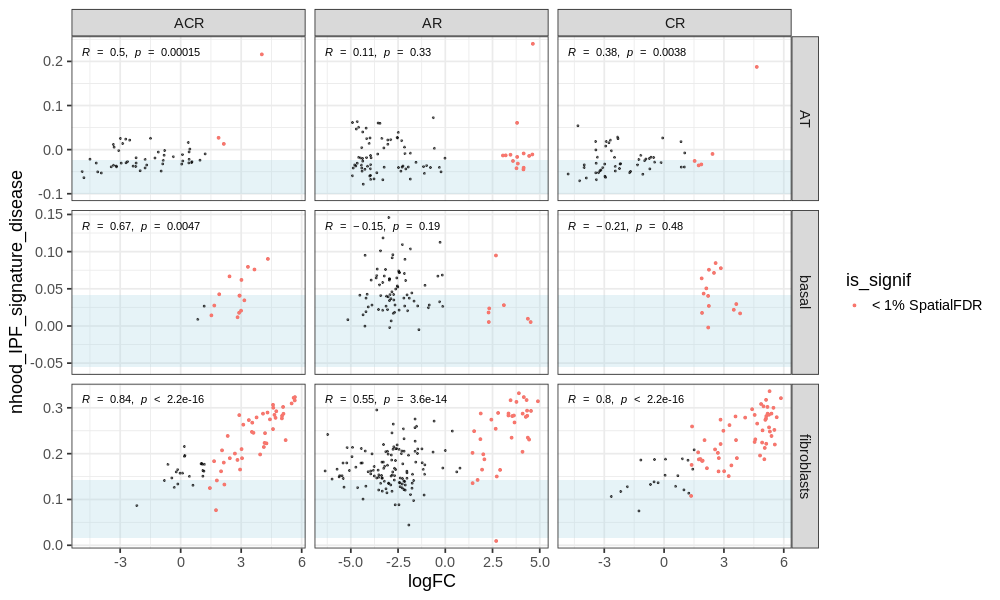

In [793]:
%%R -w 1000 -h 600
ct_groups = c('fibroblasts', 'basal', 'AT')

nhood_df %>%
    filter(nhood_annotation_group %in% ct_groups) %>%
    mutate(
        null_min=null_sign_range[nhood_annotation_group,'null_min'],
        null_max=null_sign_range[nhood_annotation_group,'null_max']
    ) %>%
    mutate(is_signif = ifelse((SpatialFDR < 0.01 & logFC > 0), '< 1% SpatialFDR', NA)) %>%
    ggplot(aes(logFC, nhood_IPF_signature_disease)) +
    geom_rect(
        data = . %>% group_by(nhood_annotation_group) %>% summarise(null_min = first(null_min), null_max = first(null_max), logFC=first(logFC), nhood_IPF_signature_disease=first(nhood_IPF_signature_disease)),
        fill = "lightblue", alpha = 0.3, 
        xmin = -Inf, xmax = +Inf,
        aes(ymin = null_min, ymax = null_max)) +
    geom_point(size=0.7, color='black', alpha=0.6) +
    geom_point(data=. %>% filter(!is.na(is_signif)),
               size = 1.1,
               aes(color=is_signif)) +
    facet_grid(nhood_annotation_group~design, scale='free') +
    theme_bw(base_size=18) +
    ggpubr::stat_cor()

In [27]:
ar_adata.uns['nhood_adata'] = ar_adata.uns['nhood_adata'].to_memory()
cr_adata.uns['nhood_adata'] = cr_adata.uns['nhood_adata'].to_memory()

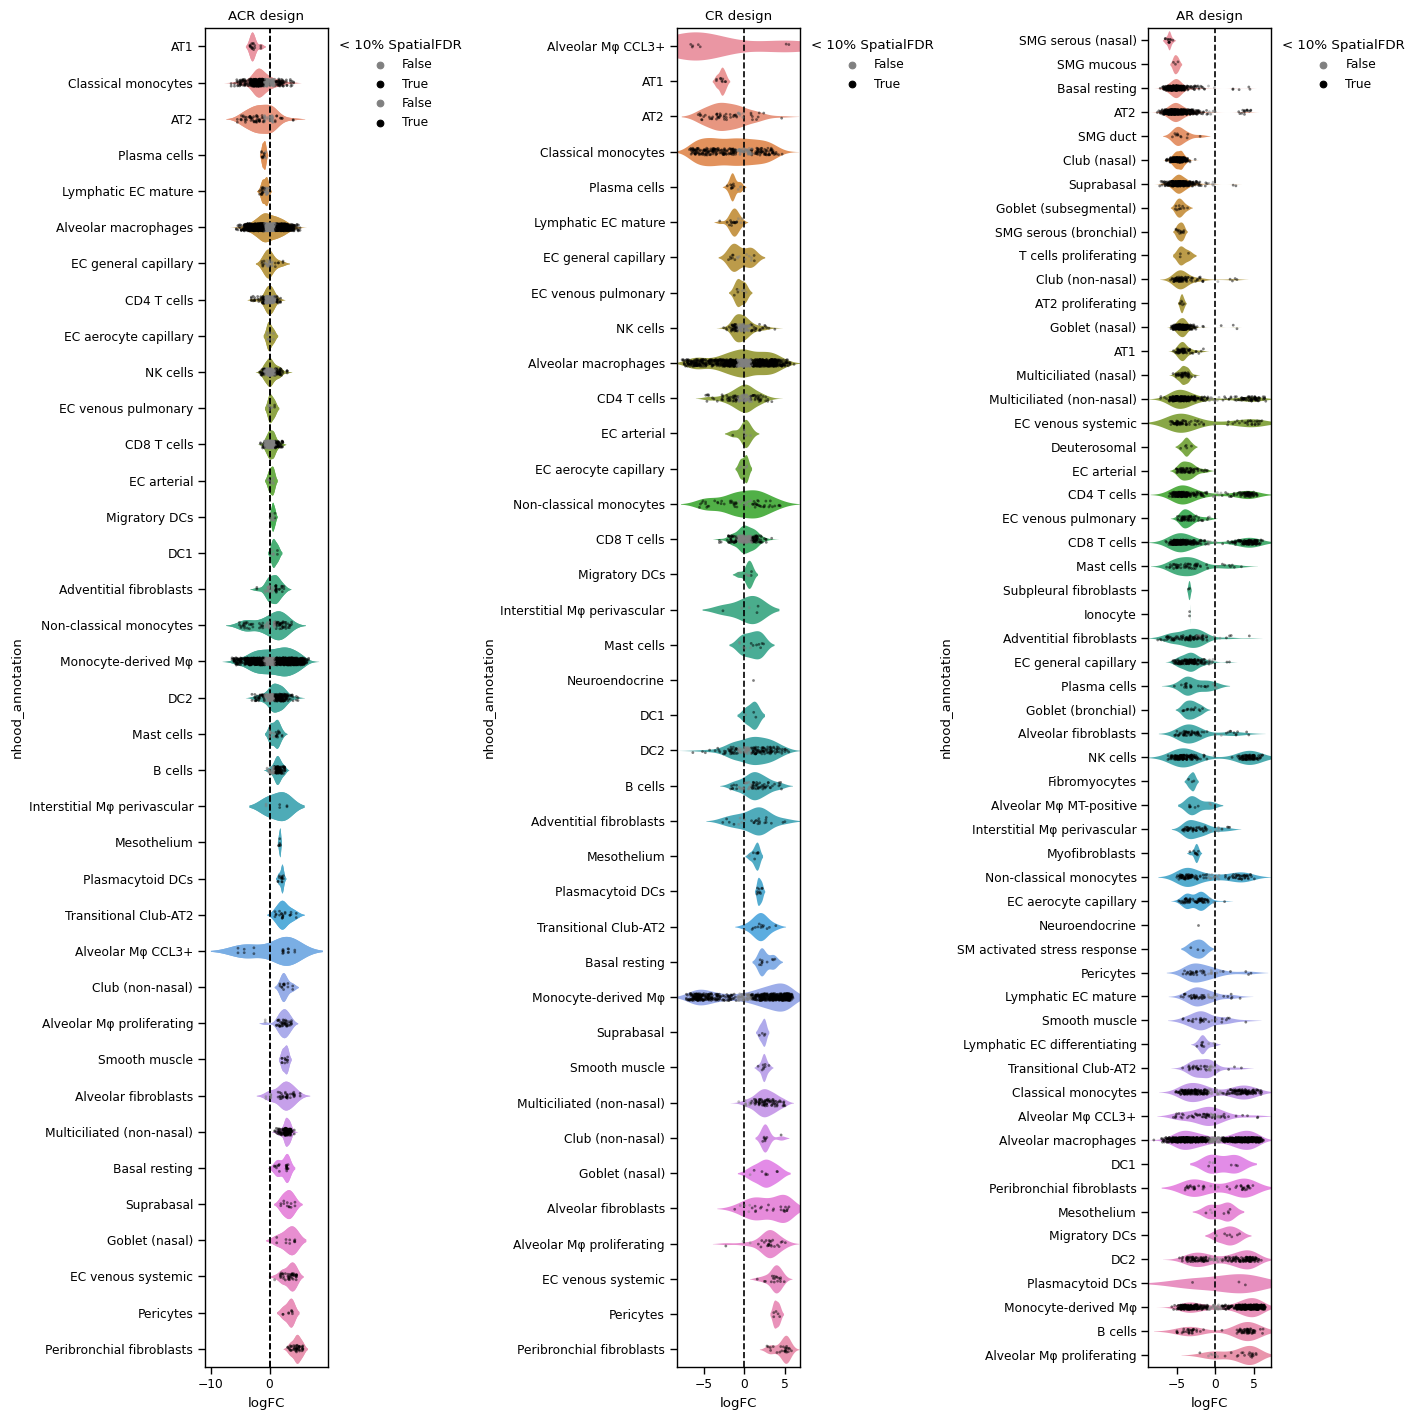

In [28]:
sns.set_context('paper')
with plt.rc_context({'figure.figsize':[14,14]}):
    plt.subplot(1,3,1);
    milopy.plot.plot_DA_beeswarm(acr_adata);
    plt.title("ACR design");
    plt.subplot(1,3,2);
    milopy.plot.plot_DA_beeswarm(cr_adata);
    plt.tight_layout(pad=0.0);
    plt.title("CR design");
    plt.subplot(1,3,3);
    milopy.plot.plot_DA_beeswarm(ar_adata);
    plt.tight_layout(pad=0.0);
    plt.title("AR design");
    plt.show()


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


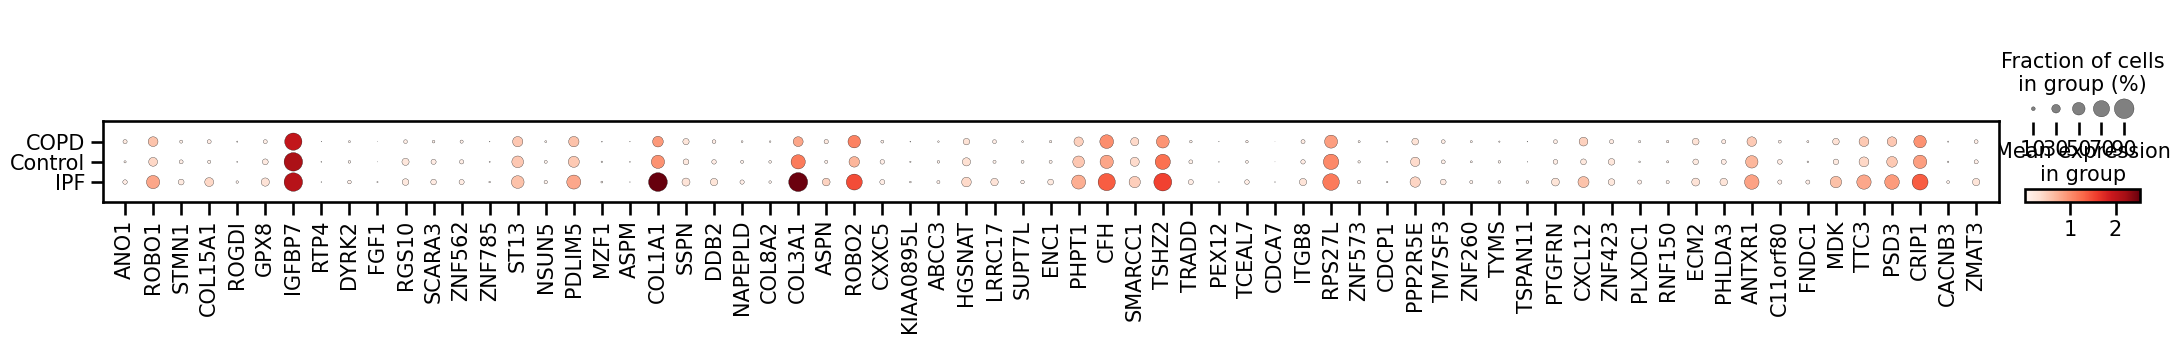

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


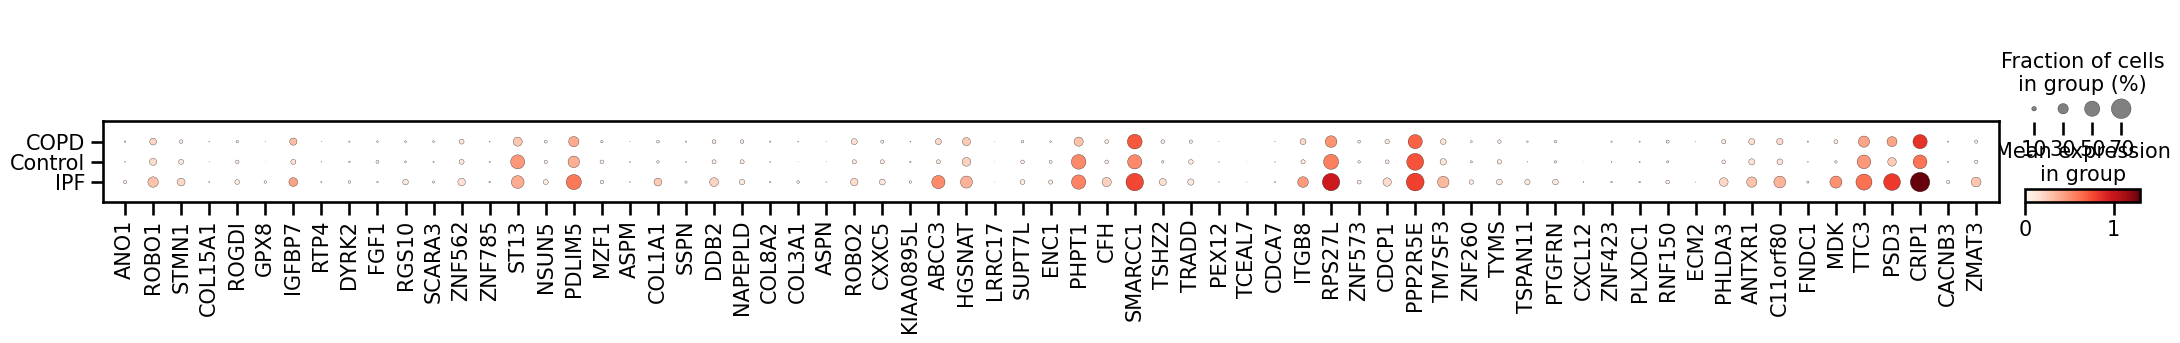

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


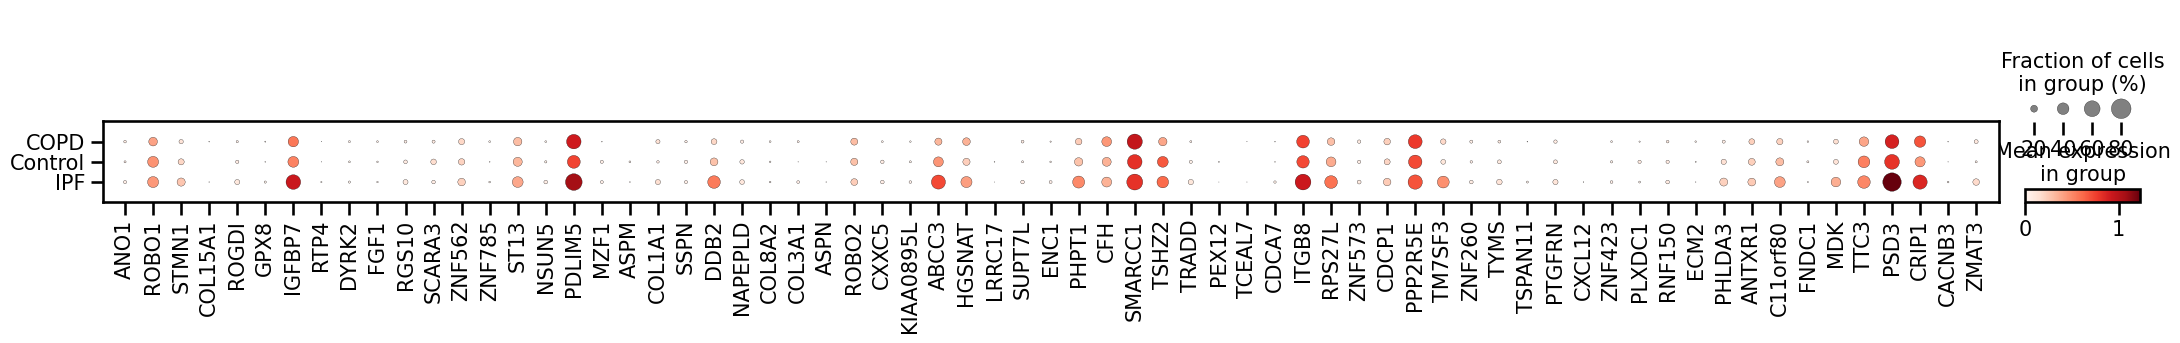

In [808]:
sc.pl.dotplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['fibroblasts'])], IPF_signature_up, groupby='disease')
sc.pl.dotplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['AT'])], IPF_signature_up, groupby='disease')
sc.pl.dotplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])], IPF_signature_up, groupby='disease')

## SPP1 macs

In [419]:
IPF_mac_signature = ['SPP1', "MMP9", "MERTK"]
g = IPF_mac_signature[0]

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


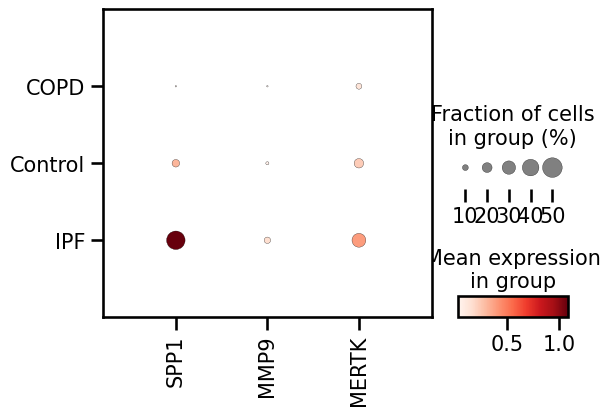

In [146]:
sc.pl.dotplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['macrophages'])], IPF_mac_signature, groupby='disease', figsize=[6,4])

In [61]:
acr_adata.obs['SPP1_expression'] = acr_adata[:,'SPP1'].X.toarray().flatten()
df = acr_adata.obs[['SPP1_expression', 'CellType_Category', 'disease', 'individual']]

In [83]:
mean_expr = df.groupby(['CellType_Category', 'disease']).mean('SPP1_expression').reset_index()
df.loc[df['SPP1_expression'] > 0, 'SPP1_expression'] = 1
n_expr = df.groupby(['CellType_Category', 'disease']).sum('SPP1_expression').reset_index()
n_expr.columns = ['CellType_Category', 'disease', 'n_expressing']
n_all = df.groupby(['CellType_Category', 'disease']).size().reset_index()
n_all.columns = ['CellType_Category', 'disease', 'tot_cells']
df = pd.merge(pd.merge(mean_expr, n_expr), n_all)

In [85]:
%%R -i df
head(df)

  CellType_Category disease SPP1_expression n_expressing tot_cells
0       Endothelial    COPD      0.01133391           13      1147
1       Endothelial Control      0.02701465           59      2184
2       Endothelial     IPF      0.19187742          789      4112
3        Epithelial    COPD      0.01268231           40      3154
4        Epithelial Control      0.07343458          353      4807
5        Epithelial     IPF      0.25175831         3329     13223


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


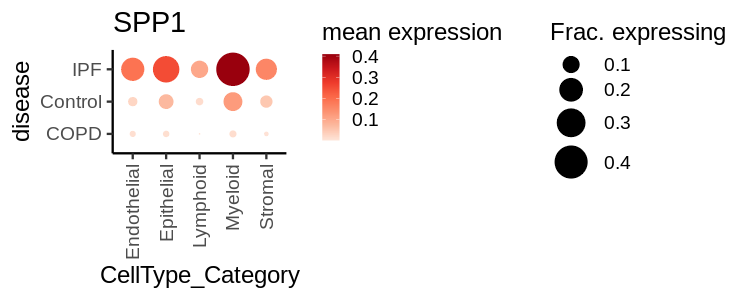

In [114]:
%%R -w 750 -h 300
df %>%
ggplot(aes(CellType_Category, disease)) +
geom_point(aes(size=n_expressing/tot_cells, color=SPP1_expression)) +
scale_color_distiller(palette = "Reds", direction=1, "mean expression") +
scale_size(range=c(0,15), name='Frac. expressing') +
theme_classic(base_size=24) +
ggtitle("SPP1") +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1), legend.box = "horizontal")

In [116]:
df = acr_adata.obs[['SPP1_expression', 'CellType_Category', 'disease', 'individual']]
mean_expr = df.groupby(['CellType_Category', 'disease', 'individual']).mean('SPP1_expression').reset_index()
df.loc[df['SPP1_expression'] > 0, 'SPP1_expression'] = 1
n_expr = df.groupby(['CellType_Category', 'disease', 'individual']).sum('SPP1_expression').reset_index()
n_expr.columns = ['CellType_Category', 'disease', 'individual','n_expressing']
n_all = df.groupby(['CellType_Category', 'disease', 'individual']).size().reset_index()
n_all.columns = ['CellType_Category', 'disease', 'individual','tot_cells']
df = pd.merge(pd.merge(mean_expr, n_expr), n_all)

In [120]:
%%R -i df
head(df)

  CellType_Category disease individual SPP1_expression n_expressing tot_cells
0       Endothelial    COPD       001C             NaN            0         0
1       Endothelial    COPD       002C             NaN            0         0
2       Endothelial    COPD       003C             NaN            0         0
3       Endothelial    COPD        8CO      0.01876928            1        28
4       Endothelial    COPD       010I             NaN            0         0
5       Endothelial    COPD       021I             NaN            0         0


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


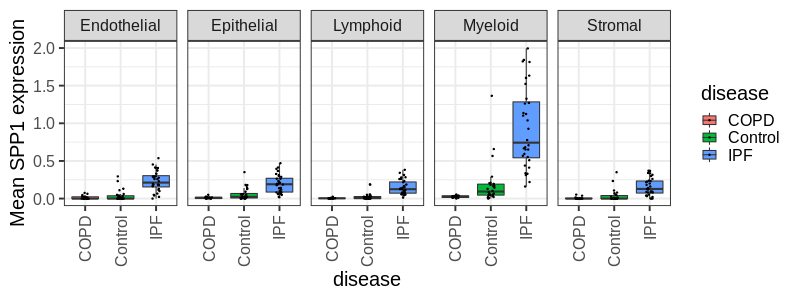

In [143]:
%%R -w 800 -h 300
df %>%
# filter(CellType_Category == 'Myeloid') %>%
ggplot(aes(disease, SPP1_expression, fill=disease)) +
geom_boxplot(outlier.alpha=0) +
geom_jitter(width=0.1, size=0.5) +
facet_wrap(CellType_Category~., nrow=1) +
ylab("Mean SPP1 expression") +
# scale_color_distiller(palette = "Reds", direction=1, "mean expression") +
# scale_size(range=c(0,15), name='Frac. expressing') +
theme_bw(base_size=20) +
# ggtitle("SPP1") +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1), legend.box = "horizontal")

In [420]:
def mark_SPP1_macs(acr_adata):
    ## Define SPP1-hi macrophages
    SPP1hi_macs = acr_adata.obs_names[(acr_adata.obs['disease'] == 'IPF') & 
                                    (acr_adata[:,"SPP1"].X.toarray().flatten() > 1.0) & 
                                    (acr_adata.obs['Celltype_HLCA'].isin(ct_groups['macrophages']))]
   
    acr_adata.obs['SPP1_macs'] = np.nan
    acr_adata.obs.loc[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['macrophages']), 'SPP1_macs'] = 'SPP1lo'
    acr_adata.obs.loc[SPP1hi_macs, 'SPP1_macs'] = 'SPP1hi'
    
mark_SPP1_macs(acr_adata)    

mark_SPP1_macs(ar_adata)

cr_adata.var_names = cr_adata.var['gene_name'].values

mark_SPP1_macs(cr_adata)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


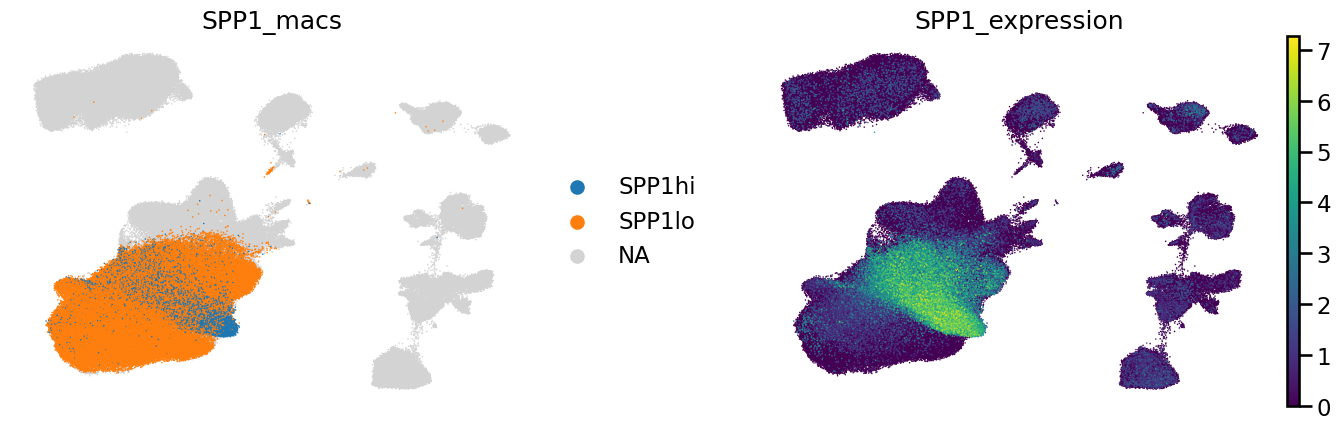

In [153]:
sc.pl.umap(acr_adata, color=['SPP1_macs', 'SPP1_expression'], size=5, wspace=0.3, frameon=False)

In [423]:
milopy.utils.annotate_nhoods(acr_adata, anno_col='SPP1_macs')
milopy.utils.annotate_nhoods(ar_adata, anno_col='SPP1_macs')
milopy.utils.annotate_nhoods(cr_adata, anno_col='SPP1_macs')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


In [ ]:
# cr_adata.uns['nhood_adata'].obs.drop('nhood_HLCA_label_transfer_uncertainty', axis=1, inplace=True)
# ar_adata.uns['nhood_adata'].obs.drop('nhood_HLCA_label_transfer_uncertainty', axis=1, inplace=True)
# acr_adata.uns['nhood_adata'].obs.drop('nhood_HLCA_label_transfer_uncertainty', axis=1, inplace=True)

In [424]:
nhood_ACR_df = acr_adata.uns['nhood_adata'].obs.copy()
nhood_ACR_df['design'] = 'ACR'
nhood_CR_df = cr_adata.uns['nhood_adata'].obs.copy()
nhood_CR_df['design'] = 'CR'
nhood_AR_df = ar_adata.uns['nhood_adata'].obs.copy()
nhood_AR_df['design'] = 'AR'

nhood_df = pd.concat([nhood_ACR_df.dropna(), nhood_CR_df.dropna(), nhood_AR_df.dropna()])

In [ ]:
%%R -i nhood_df
head(nhood_df)

In [ ]:
%%R -w 1800 -h 500
nhood_df %>%
mutate(frac_SPP1_macs = ifelse(nhood_annotation == 'SPP1lo', 1- nhood_annotation_frac, nhood_annotation_frac)) %>%
mutate(is_signif = ifelse((SpatialFDR < 0.01 & logFC > 0), '< 1% SpatialFDR', NA)) %>%
ggplot(aes(logFC, frac_SPP1_macs)) +
geom_point(size=0.7, color='black', alpha=0.6) +
geom_point(data=. %>% filter(!is.na(is_signif)),
           size = 1.1,
           aes(color=is_signif)) +
theme_bw(base_size=28) +
ylab("Frac. SPP1hi macs") +
facet_grid(.~design) 

In [ ]:
%%R -w 1500 -h 500
nhood_df %>%
mutate(frac_SPP1_macs = ifelse(nhood_annotation == 'SPP1lo', 1- nhood_annotation_frac, nhood_annotation_frac)) %>%
mutate(is_signif = ifelse(SpatialFDR < 0.01, '< 1% SpatialFDR', NA)) %>%
ggplot(aes(logFC, nhood_annotation)) +
geom_violin() +
theme_bw(base_size=18) +
facet_grid(.~design) 

In [ ]:
from oor_benchmark.metrics import auprc

nhood_df['OOR_state_group'] = (nhood_df['nhood_annotation'] == 'SPP1hi').astype('int')
nhood_df['OOR_score'] = nhood_df['logFC']

auprc_acr = auprc.auprc(nhood_df[nhood_df.design == 'ACR'], return_curve=True)
auprc_acr['design'] = 'ACR'
auprc_ar = auprc.auprc(nhood_df[nhood_df.design == 'AR'], return_curve=True)
auprc_ar['design'] = 'AR'
auprc_cr = auprc.auprc(nhood_df[nhood_df.design == 'CR'], return_curve=True)
auprc_cr['design'] = 'CR'
auprc_df = pd.concat([auprc_cr, auprc_acr, auprc_ar])

In [ ]:
%%R -i auprc_df
head(auprc_df)

In [ ]:
%%R
pl_df <- auprc_df %>%
mutate(design_labels = str_c(design, ' (AUPRC = ', round(AUPRC, 2), ')')) 

des_labels = pl_df %>%
    distinct(design, design_labels) 

pl_df %>%
ggplot(aes(Recall, Precision, color=design)) +
geom_line(size=1) +
geom_hline(data=. %>% group_by(design) %>% summarise(no_skill_thresh = first(no_skill_thresh)), 
           linetype=2, aes(yintercept=no_skill_thresh, color=design)) +
scale_color_manual(values=design_palette, labels = setNames(des_labels$design_labels, des_labels$design)) +
guides(color=guide_legend(ncol=1, title.position='top')) +
theme_bw(base_size=28) +
theme(legend.position='top', legend.justification='right') 


### Compare to uncertainty score

In [220]:
milopy.utils.annotate_nhoods_continuous(acr_adata, 'HLCA_label_transfer_uncertainty')
nhood_df = acr_adata.uns['nhood_adata'].obs.dropna().copy()

In [307]:
nhood_df['OOR_state_group'] = (nhood_df['nhood_annotation'] == 'SPP1hi').astype('int')
nhood_df['OOR_score'] = nhood_df['logFC']
auprc_DA = auprc.auprc(nhood_df, return_curve=True)
auprc_DA['metric'] = 'DA logFC'
nhood_df['OOR_score'] = nhood_df['nhood_HLCA_label_transfer_uncertainty']
auprc_unc = auprc.auprc(nhood_df, return_curve=True)
auprc_unc['metric'] = 'mean label transfer uncertainty'

df1['OOR_state_group'] = (df1['SPP1_macs'] == 'SPP1hi').astype('int')
df1['OOR_score'] = df1['HLCA_label_transfer_uncertainty']
auprc_unc_cells = auprc.auprc(df1, return_curve=True)
auprc_unc_cells['metric'] = 'label transfer uncertainty'
auprc_df = pd.concat([auprc_unc, auprc_DA, auprc_unc_cells])

/tmp/ipykernel_52507/379393427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['OOR_state_group'] = (df1['SPP1_macs'] == 'SPP1hi').astype('int')
/tmp/ipykernel_52507/379393427.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['OOR_score'] = df1['HLCA_label_transfer_uncertainty']


In [308]:
%%R -i auprc_df
head(auprc_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


    Recall Precision     AUPRC no_skill_thresh                          metric
1 1.000000 0.1103337 0.1100872       0.1103337 mean label transfer uncertainty
2 1.000000 0.1103931 0.1100872       0.1103337 mean label transfer uncertainty
3 1.000000 0.1104526 0.1100872       0.1103337 mean label transfer uncertainty
4 1.000000 0.1105121 0.1100872       0.1103337 mean label transfer uncertainty
5 0.995122 0.1100324 0.1100872       0.1103337 mean label transfer uncertainty
6 0.995122 0.1100917 0.1100872       0.1103337 mean label transfer uncertainty


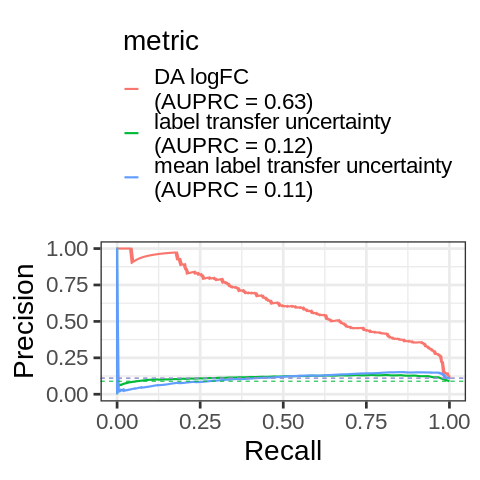

In [309]:
%%R
pl_df <- auprc_df %>%
mutate(metric = str_c(metric, '\n(AUPRC = ', round(AUPRC, 2), ')')) 

pl_df %>%
ggplot(aes(Recall, Precision, color=metric)) +
geom_line(size=1) +
geom_hline(data=. %>% group_by(metric) %>% summarise(no_skill_thresh = first(no_skill_thresh)), 
           linetype=2, aes(yintercept=no_skill_thresh, color=metric)) +
guides(color=guide_legend(ncol=1, title.position='top')) +
theme_bw(base_size=28) +
theme(legend.position='top', legend.justification='right') 


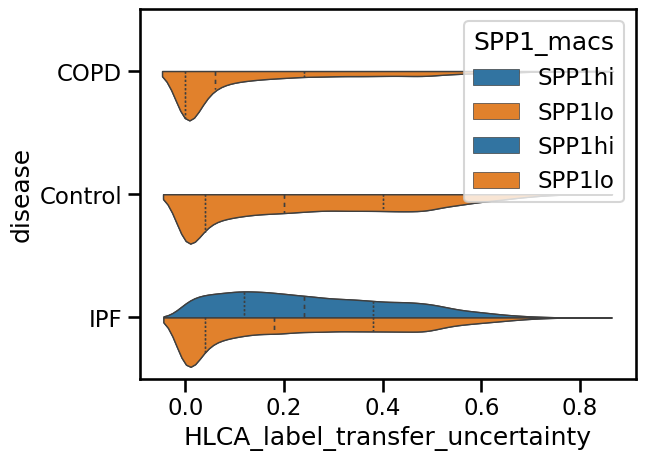

In [233]:
df1 = acr_adata.obs[['disease', 'SPP1_macs', 'HLCA_label_transfer_uncertainty']]
sns.violinplot(data=df1, y='disease', x='SPP1_macs', hue="SPP1_macs",
                        split=True, inner="quart", linewidth=1);
plt.show()

In [261]:
df1 = df1.dropna()
df1['OOR_state_group'] = (df1['SPP1_macs'] == 'SPP1hi').astype('int')
df1['OOR_score'] = df1['HLCA_label_transfer_uncertainty']
auprc_unc_cells = auprc.auprc(df1, return_curve=True)
auprc_unc_cells

/tmp/ipykernel_52507/982420798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['OOR_state_group'] = (df1['SPP1_macs'] == 'SPP1hi').astype('int')
/tmp/ipykernel_52507/982420798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['OOR_score'] = df1['HLCA_label_transfer_uncertainty']


Recall  Precision     AUPRC  no_skill_thresh
0      1.000000   0.171885  0.193833         0.171885
1      0.977090   0.189018  0.193833         0.171885
2      0.968957   0.195488  0.193833         0.171885
3      0.966669   0.197218  0.193833         0.171885
4      0.966633   0.197340  0.193833         0.171885
...         ...        ...       ...              ...
57802  0.000000   0.000000  0.193833         0.171885
57803  0.000000   0.000000  0.193833         0.171885
57804  0.000000   0.000000  0.193833         0.171885
57805  0.000000   0.000000  0.193833         0.171885
57806  0.000000   1.000000  0.193833         0.171885

[57807 rows x 4 columns]

In [278]:
df1 = acr_adata.obs[['disease', 'SPP1_macs', 'HLCA_label_transfer_uncertainty']]
df1['SPP1_macs'] = df1['SPP1_macs'].cat.reorder_categories(['SPP1lo', "SPP1hi"])

/tmp/ipykernel_52507/2439616347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['SPP1_macs'] = df1['SPP1_macs'].cat.reorder_categories(['SPP1lo', "SPP1hi"])


In [299]:
spp1_palette = {'SPP1hi':'salmon', 'SPP1lo':'lightgray'}

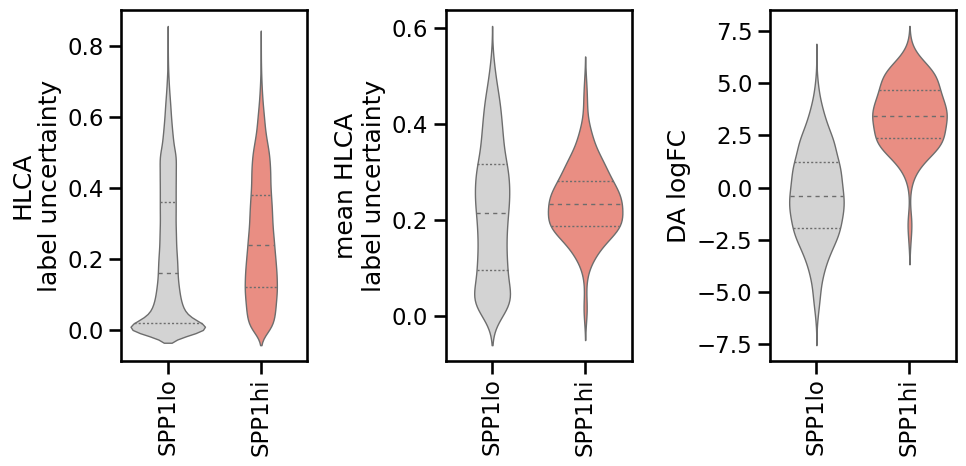

In [302]:
with plt.rc_context({'figure.figsize':[10,5]}):
    plt.subplot(1,3,1);
    sns.violinplot(data=df1, y='HLCA_label_transfer_uncertainty', x='SPP1_macs', 
                             inner="quart", linewidth=1, palette=spp1_palette);
    plt.ylabel('HLCA\nlabel uncertainty'); plt.xlabel('');
    plt.legend([],[], frameon=False);
    plt.xticks(rotation=90, ha='center');
    plt.subplot(1,3,2);
    sns.violinplot(data=nhood_df, x='nhood_annotation', y='nhood_HLCA_label_transfer_uncertainty',
            inner="quart", linewidth=1, palette=spp1_palette);
    plt.ylabel('mean HLCA\nlabel uncertainty');
    plt.xlabel('');
    plt.legend([],[], frameon=False);
    plt.xticks(rotation=90, ha='center');
    plt.subplot(1,3,3);
    sns.violinplot(data=nhood_df, x='nhood_annotation', y='logFC',
            inner="quart", linewidth=1, palette=spp1_palette);
    plt.ylabel('DA logFC');
    plt.xlabel('');
    plt.legend([],[], frameon=False);
    plt.xticks(rotation=90, ha='center');
    plt.tight_layout();
    plt.show()

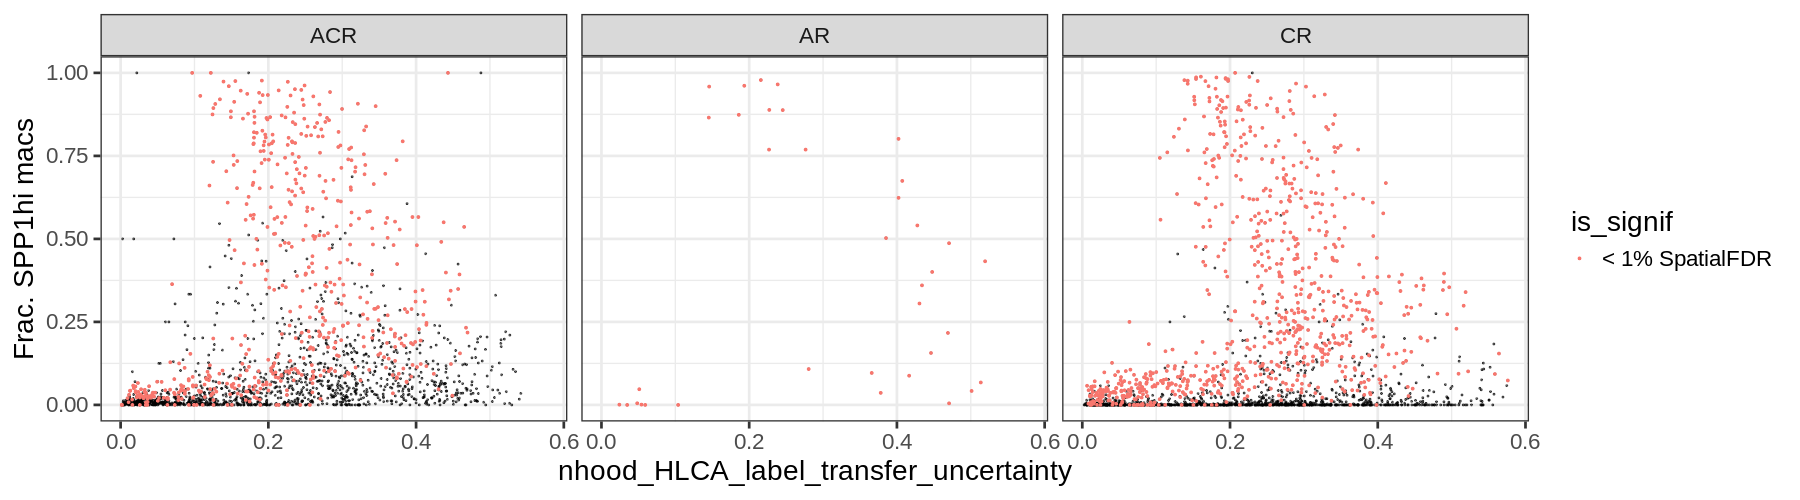

In [214]:
%%R -w 1800 -h 500
nhood_df %>%
mutate(frac_SPP1_macs = ifelse(nhood_annotation == 'SPP1lo', 1- nhood_annotation_frac, nhood_annotation_frac)) %>%
mutate(is_signif = ifelse((SpatialFDR < 0.01 & logFC > 0), '< 1% SpatialFDR', NA)) %>%
ggplot(aes(nhood_HLCA_label_transfer_uncertainty, frac_SPP1_macs)) +
geom_point(size=0.7, color='black', alpha=0.6) +
geom_point(data=. %>% filter(!is.na(is_signif)),
           size = 1.1,
           aes(color=is_signif)) +
theme_bw(base_size=28) +
ylab("Frac. SPP1hi macs") +
facet_grid(.~design) 

### Check the false positives in CR design

In [432]:
nhood_ACR_df = acr_adata.uns['nhood_adata'].obs.copy()
nhood_ACR_df['design'] = 'ACR'
nhood_CR_df = cr_adata.uns['nhood_adata'].obs.copy()
nhood_CR_df['design'] = 'CR'
nhood_AR_df = ar_adata.uns['nhood_adata'].obs.copy()
nhood_AR_df['design'] = 'AR'

keep_cols = ['nhood_annotation',
       'nhood_annotation_frac', 'logFC', 'logCPM', 'F', 'PValue', 'FDR',
       'SpatialFDR','design']
nhood_df = pd.concat([nhood_ACR_df[keep_cols].dropna(), nhood_CR_df[keep_cols].dropna(), nhood_AR_df[keep_cols].dropna()])

In [525]:
def get_FP_nhs(design, top_perc = 0.05, anno_frac = 0.8):
    CR_df = nhood_df[nhood_df['design'] == design]
    top_CR_df = CR_df.sort_values('logFC', ascending=False)[0:int(CR_df.shape[0]*top_perc)]
    FP_nhs = top_CR_df[(top_CR_df.nhood_annotation == 'SPP1lo') & (top_CR_df.nhood_annotation_frac > anno_frac)].index
    return(FP_nhs, top_CR_df.index[~top_CR_df.index.isin(FP_nhs)])

In [636]:
fp_CR, other_CR = get_FP_nhs('CR', top_perc=0.05)
fp_ACR, other_ACR = get_FP_nhs('ACR', top_perc=0.05)

In [637]:
print(f'Frac.FP in CR: {fp_CR.shape[0]/(fp_CR.shape[0] + other_CR.shape[0])}')
print(f'Frac.FP in ACR: {fp_ACR.shape[0]/(fp_ACR.shape[0] + other_ACR.shape[0])}')

Frac.FP in CR: 0.20408163265306123
Frac.FP in ACR: 0.07608695652173914


In [638]:
## Add number of samples per nhood
nhood_adata = cr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
cr_adata.uns['nhood_adata'].obs['n_samples'] = np.array(milo_mat.sum(1)).flatten()

nhood_adata = acr_adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
acr_adata.uns['nhood_adata'].obs['n_samples'] = np.array(milo_mat.sum(1)).flatten()

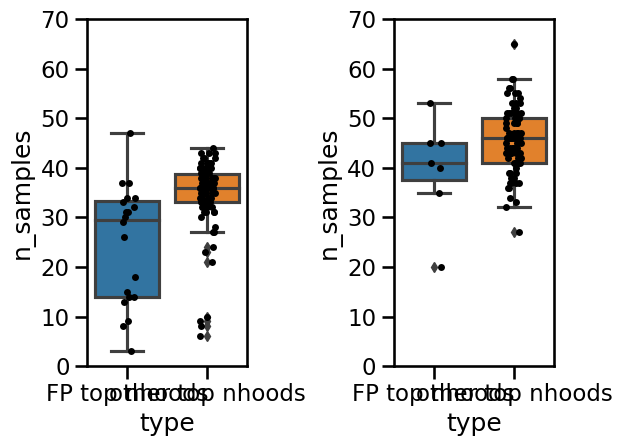

In [639]:
df_fp = pd.DataFrame(cr_adata.uns['nhood_adata'][fp_CR,:].obs['n_samples'])
df_fp['type'] = 'FP top nhoods'
df_oth = pd.DataFrame(cr_adata.uns['nhood_adata'][other_CR,:].obs['n_samples'])
df_oth['type'] = 'other top nhoods'
pl_df = pd.concat([df_fp, df_oth])

plt.subplot(1,2,1);
sns.boxplot(data=pl_df, x='type', y='n_samples');
sns.stripplot(data=pl_df, x='type', y='n_samples', color='black');
plt.ylim(0,70);

df_fp = pd.DataFrame(acr_adata.uns['nhood_adata'][fp_ACR,:].obs['n_samples'])
df_fp['type'] = 'FP top nhoods'
df_oth = pd.DataFrame(acr_adata.uns['nhood_adata'][other_ACR,:].obs['n_samples'])
df_oth['type'] = 'other top nhoods'
pl_df = pd.concat([df_fp, df_oth])

plt.subplot(1,2,2);
sns.boxplot(data=pl_df, x='type', y='n_samples');
sns.stripplot(data=pl_df, x='type', y='n_samples', color='black');
plt.ylim(0,70);
plt.tight_layout();
plt.show()

In [645]:
ct_df = cr_adata.uns['nhood_adata'][fp_CR,:].to_df().reset_index().melt(id_vars=['index'],value_name = 'n_cells', var_name='individual')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


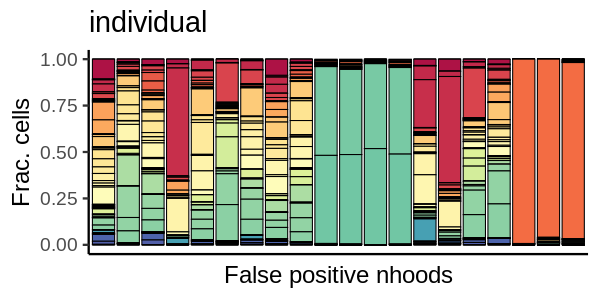

In [647]:
%%R -i ct_df -w 600 -h 300
library(RColorBrewer)
ct_df %>%
ggplot(aes(index, n_cells, fill=individual)) +
geom_col(position='fill', color='black') +
scale_fill_manual(values = colorRampPalette(brewer.pal(12, "Spectral"))(length(unique(ct_df$individual)))) +
guides(fill='none') +
theme_classic(base_size=24) +
xlab('False positive nhoods') + ylab('Frac. cells') +
ggtitle("individual") +
theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
# scale_fill_distiller(palette='Spectral')

In [642]:
ct_df = acr_adata.uns['nhood_adata'][fp_ACR,:].to_df().reset_index().melt(id_vars=['index'],value_name = 'n_cells', var_name='individual')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


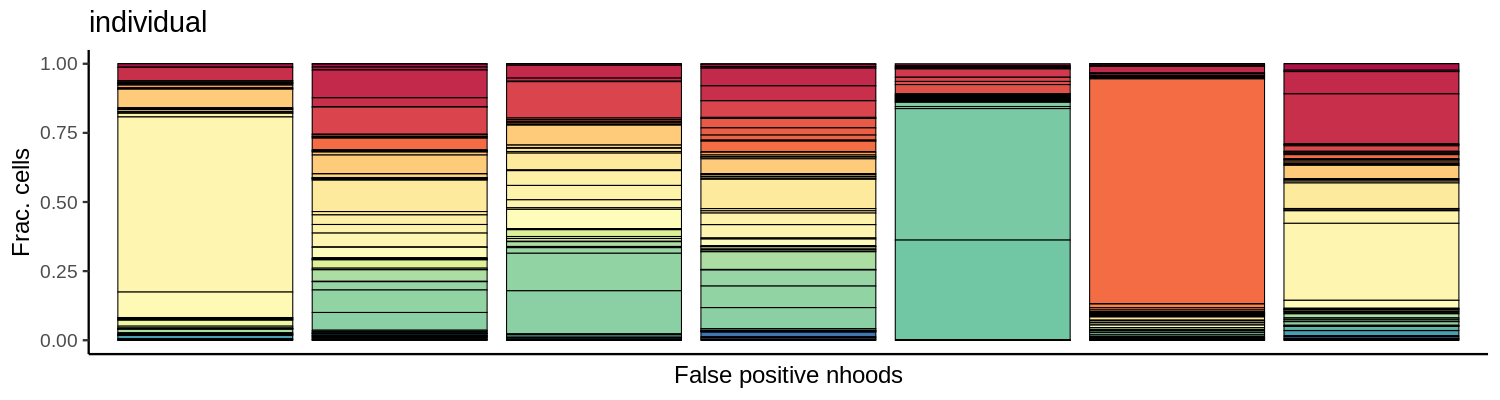

In [643]:
%%R -i ct_df -w 1500 -h 400
library(RColorBrewer)
ct_df %>%
ggplot(aes(index, n_cells, fill=individual)) +
geom_col(position='fill', color='black') +
scale_fill_manual(values = colorRampPalette(brewer.pal(12, "Spectral"))(length(unique(ct_df$individual)))) +
guides(fill='none') +
theme_classic(base_size=24) +
xlab('False positive nhoods') + ylab('Frac. cells') +
ggtitle("individual") +
theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
# scale_fill_distiller(palette='Spectral')

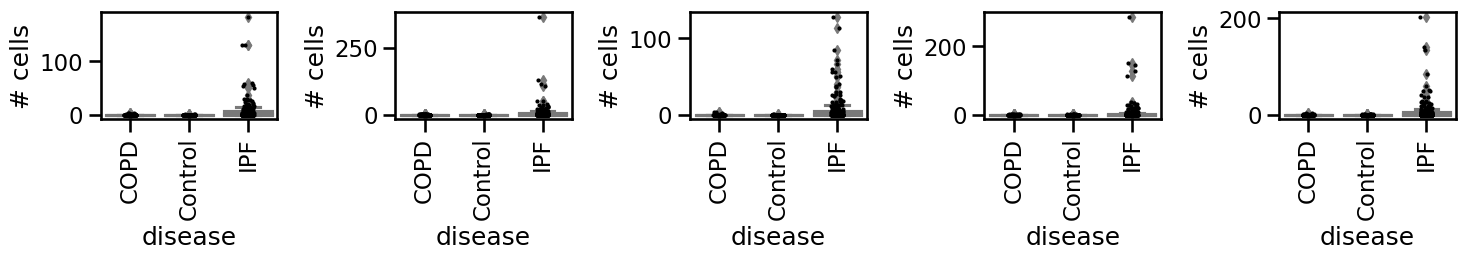

In [582]:
sns.set_context('talk')
n_iters=5
with plt.rc_context({'figure.figsize':[15,3]}):
    for i in np.arange(n_iters):
        plt.subplot(1,n_iters, i+1);
        subset_nhs = np.random.choice(fp_CR, n_iters, replace=False)
        milopy.plot.plot_nhood_counts_by_cond(cr_adata, test_var='disease', subset_nhoods=subset_nhs, log_counts=False);
    plt.tight_layout()
    plt.show()

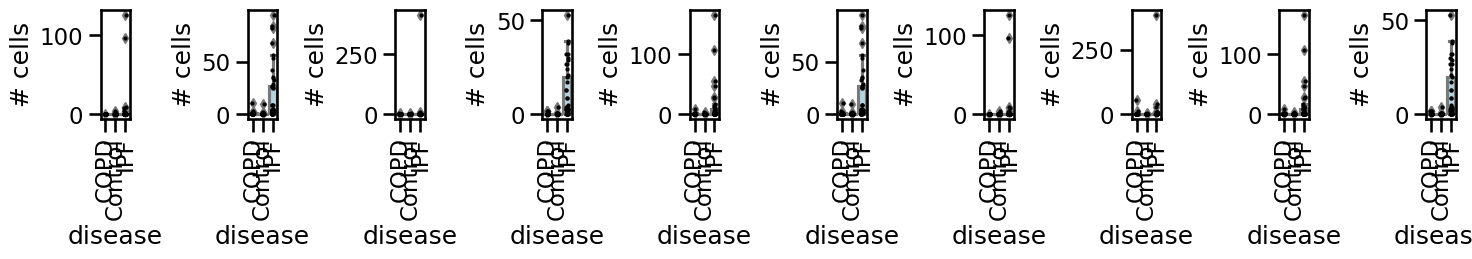

In [578]:
sns.set_context('talk')
n_iters=10
with plt.rc_context({'figure.figsize':[15,3]}):
    for i in np.arange(n_iters):
        plt.subplot(1,n_iters, i+1);
        milopy.plot.plot_nhood_counts_by_cond(acr_adata, test_var='disease', subset_nhoods=np.random.choice(fp_ACR, 1), log_counts=False);
    plt.tight_layout()
    plt.show()

In [521]:
TP_nhs_ACR.shape[0] /(TP_nhs_ACR.shape[0] + FP_nhs_ACR.shape[0])

0.7482014388489209

In [460]:
fp_mat = cr_adata.uns['nhood_adata'][FP_nhs,:].X.toarray()
ipf_sample_ixs = np.where(cr_adata.uns['nhood_adata'].var['disease'] == 'IPF')[0]

fp_mat

array([ 4,  5,  8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25,
       26, 28, 29, 37, 39, 40, 45, 46, 47, 52, 53, 54, 55, 57, 58, 59, 61,
       74, 75, 76, 77, 83, 85, 86, 87, 88, 91, 92])

----

## That funky AT2 nhood

In [56]:
nhood_df[(nhood_df['nhood_annotation'] == 'AT2') & (nhood_df['logFC'] >3)]

index_cell  kth_distance     logFC    logCPM         F  \
796  138I-a_GAAATGAGTTCAGACT      2.911601  4.022426  8.654254  59.06127   

           PValue           FDR    SpatialFDR  nhood_IPF_signature  \
796  2.206851e-12  3.457216e-11  3.986237e-11             0.199166   

    nhood_annotation  nhood_annotation_frac nhood_annotation_group  
796              AT2                0.62069                     AT

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


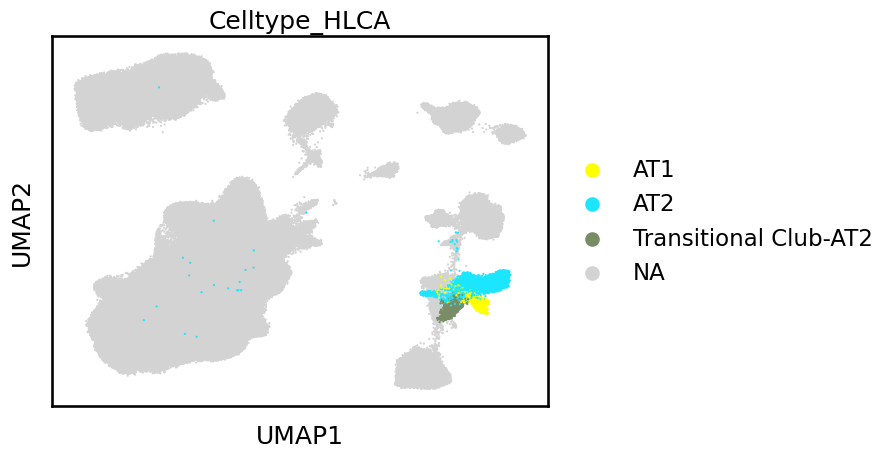

In [105]:
sc.pl.umap(acr_adata, color='Celltype_HLCA', groups=ct_groups['AT'], size=10)

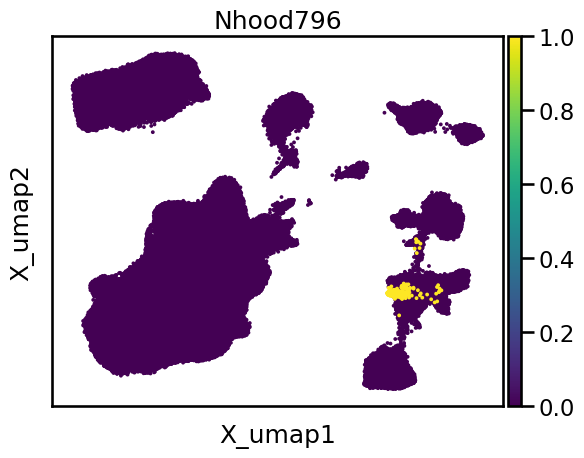

In [104]:
milopy.plot.plot_nhood(acr_adata, 796)